# Flight Delay and Cancellation Analysis (2019-2023)
## Database-First Approach with DuckDB and SQL

## 1. Introduction

Flight delays and cancellations are persistent challenges in the aviation industry, impacting millions of travelers each year and posing significant operational and financial hurdles for airlines. Understanding the underlying causes and patterns of these disruptions is crucial for improving service reliability, optimizing schedules, and enhancing the overall passenger experience.

**Analytical Approach:** This notebook demonstrates a **database-first workflow** using DuckDB and SQL for all data processing and analysis, with Python reserved exclusively for visualization. This approach mirrors production data engineering practices and provides superior performance and scalability compared to traditional in-memory pandas operations.

---

## 2. Dataset Overview

**Source:** U.S. Department of Transportation's Bureau of Transportation Statistics  
**Time Period:** January 2019 - August 2023  
**Size:** ~3 million records, 32 attributes  
**Scope:** Domestic flight operations across the United States

**Key Features:**
- **Flight Details:** Date, time, airline, flight number, origin/destination airports
- **Operational Status:** Completed, delayed, canceled, or diverted indicators
- **Delay Metrics:** Total delay minutes with cause breakdowns (carrier, weather, NAS, security, late aircraft)
- **Cancellation Reasons:** Categorical reasons for cancellations
- **Time Data:** Scheduled and actual departure/arrival times

---

## 3. Setup and Initial Data Loading

### 3.1 Import Required Libraries

In [1]:
# Core libraries
import kagglehub
import os

# Database
import duckdb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Scikit-Learn Modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Utilities
from IPython.display import display
import warnings

# Configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("Libraries loaded successfully")

Libraries loaded successfully


### 3.2 Download Dataset from Kaggle

In [2]:
# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download(
    'patrickzel/flight-delay-and-cancellation-dataset-2019-2023'
)

# Construct full path to CSV file
csv_file_path = os.path.join(dataset_path, 'flights_sample_3m.csv')

print(f"Dataset downloaded to: {dataset_path}")
print(f"CSV file path: {csv_file_path}")

Using Colab cache for faster access to the 'flight-delay-and-cancellation-dataset-2019-2023' dataset.
Dataset downloaded to: /kaggle/input/flight-delay-and-cancellation-dataset-2019-2023
CSV file path: /kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv


### 3.3 Initialize DuckDB and Load Raw Data

In [3]:
# Initialize in-memory DuckDB database
con = duckdb.connect(database=':memory:', read_only=False)

# Load raw CSV directly into DuckDB
con.execute(f"""
    CREATE TABLE flights_raw AS
    SELECT * FROM read_csv_auto('{csv_file_path}')
""")

print("✓ DuckDB database initialized")
print("✓ Raw data loaded into 'flights_raw' table")

# Check the data
print("\nDataset dimensions:")
dimensions = con.execute("SELECT COUNT(*) as rows, COUNT(*) as cols FROM flights_raw").fetchdf()
print(f"Rows: {dimensions['rows'][0]:,}")

print("\nFirst 5 rows:")
display(con.execute("SELECT * FROM flights_raw LIMIT 5").fetchdf())

print("\nColumn names and types:")
display(con.execute("DESCRIBE flights_raw").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ DuckDB database initialized
✓ Raw data loaded into 'flights_raw' table

Dataset dimensions:
Rows: 3,000,000

First 5 rows:


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,None,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,None,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,None,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,None,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",1840,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,None,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN



Column names and types:


,column_name,column_type,null,key,default,extra
0,FL_DATE,DATE,YES,None,None,None
1,AIRLINE,VARCHAR,YES,None,None,None
2,AIRLINE_DOT,VARCHAR,YES,None,None,None
3,AIRLINE_CODE,VARCHAR,YES,None,None,None
4,DOT_CODE,BIGINT,YES,None,None,None
5,FL_NUMBER,BIGINT,YES,None,None,None
6,ORIGIN,VARCHAR,YES,None,None,None
7,ORIGIN_CITY,VARCHAR,YES,None,None,None
8,DEST,VARCHAR,YES,None,None,None
9,DEST_CITY,VARCHAR,YES,None,None,None


## 4. Data Quality Assessment (SQL)

### 4.1 Check Missing Values

Missing Value Analysis:


,column_name,missing_count,missing_pct
0,CANCELLATION_CODE,2920860,97.36
1,DELAY_DUE_WEATHER,2466137,82.20
2,DELAY_DUE_CARRIER,2466137,82.20
3,ARR_DELAY,86198,2.87
4,FL_DATE,0,0.00
5,AIRLINE,0,0.00


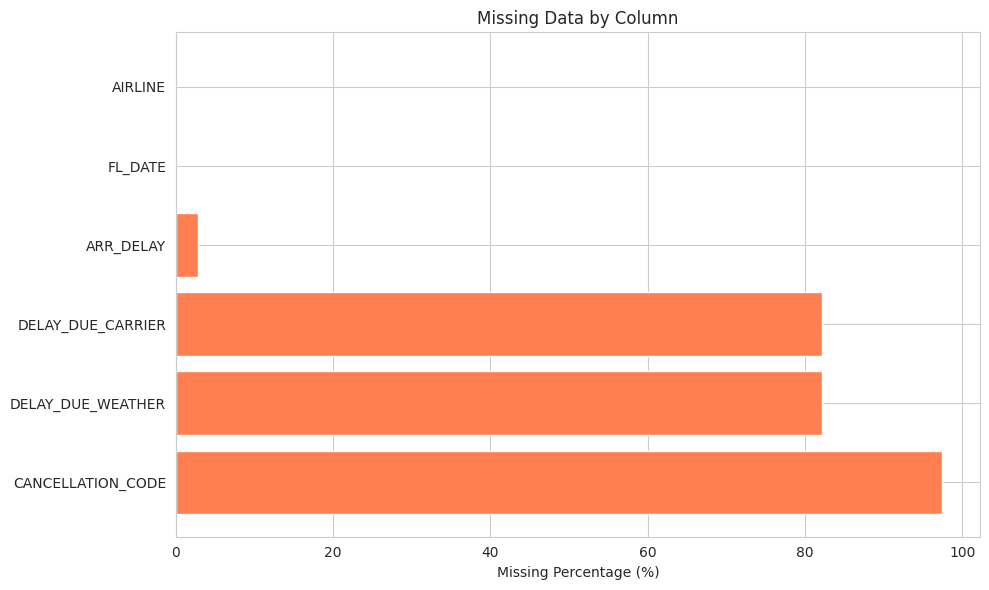

In [4]:
# Analyze missing data patterns using SQL
missing_analysis = con.execute("""
    SELECT
        'FL_DATE' as column_name,
        COUNT(*) - COUNT(FL_DATE) as missing_count,
        ROUND(100.0 * (COUNT(*) - COUNT(FL_DATE)) / COUNT(*), 2) as missing_pct
    FROM flights_raw

    UNION ALL

    SELECT 'AIRLINE', COUNT(*) - COUNT(AIRLINE),
           ROUND(100.0 * (COUNT(*) - COUNT(AIRLINE)) / COUNT(*), 2)
    FROM flights_raw

    UNION ALL

    SELECT 'ARR_DELAY', COUNT(*) - COUNT(ARR_DELAY),
           ROUND(100.0 * (COUNT(*) - COUNT(ARR_DELAY)) / COUNT(*), 2)
    FROM flights_raw

    UNION ALL

    SELECT 'CANCELLATION_CODE', COUNT(*) - COUNT(CANCELLATION_CODE),
           ROUND(100.0 * (COUNT(*) - COUNT(CANCELLATION_CODE)) / COUNT(*), 2)
    FROM flights_raw

    UNION ALL

    SELECT 'DELAY_DUE_CARRIER', COUNT(*) - COUNT(DELAY_DUE_CARRIER),
           ROUND(100.0 * (COUNT(*) - COUNT(DELAY_DUE_CARRIER)) / COUNT(*), 2)
    FROM flights_raw

    UNION ALL

    SELECT 'DELAY_DUE_WEATHER', COUNT(*) - COUNT(DELAY_DUE_WEATHER),
           ROUND(100.0 * (COUNT(*) - COUNT(DELAY_DUE_WEATHER)) / COUNT(*), 2)
    FROM flights_raw

    ORDER BY missing_pct DESC
""").fetchdf()

print("Missing Value Analysis:")
display(missing_analysis)

# Visualize missing data
plt.figure(figsize=(10, 6))
plt.barh(missing_analysis['column_name'], missing_analysis['missing_pct'], color='coral')
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column')
plt.tight_layout()
plt.show()

### 4.2 Basic Statistics

In [5]:
# Get summary statistics using SQL
stats = con.execute("""
    SELECT
        COUNT(*) as total_flights,
        COUNT(DISTINCT AIRLINE) as total_airlines,
        COUNT(DISTINCT ORIGIN) as total_origins,
        COUNT(DISTINCT DEST) as total_destinations,
        ROUND(AVG(DISTANCE), 2) as avg_distance_miles,
        ROUND(AVG(ARR_DELAY), 2) as avg_arrival_delay_min,
        SUM(CASE WHEN CANCELLED = 1 THEN 1 ELSE 0 END) as cancelled_flights,
        SUM(CASE WHEN DIVERTED = 1 THEN 1 ELSE 0 END) as diverted_flights
    FROM flights_raw
""").fetchdf()

print("Dataset Summary Statistics:")
display(stats)

Dataset Summary Statistics:


,total_flights,total_airlines,total_origins,total_destinations,avg_distance_miles,avg_arrival_delay_min,cancelled_flights,diverted_flights
0,3000000,18,380,380,809.36,4.26,79140.0,7056.0


## 5. Data Preprocessing (SQL)

### 5.1 Create Cleaned Dataset

In [6]:
# Perform all preprocessing in SQL
con.execute("""
    CREATE TABLE flights_clean AS
    SELECT
        -- Original columns
        CAST(FL_DATE AS DATE) as FL_DATE,
        AIRLINE,
        AIRLINE_CODE,
        DOT_CODE,
        FL_NUMBER,
        ORIGIN,
        ORIGIN_CITY,
        DEST,
        DEST_CITY,

        -- Time columns (keep as integers for now, will convert later)
        CRS_DEP_TIME,
        DEP_TIME,
        DEP_DELAY,
        TAXI_OUT,
        WHEELS_OFF,
        WHEELS_ON,
        TAXI_IN,
        CRS_ARR_TIME,
        ARR_TIME,
        ARR_DELAY,

        -- Status columns
        CANCELLED,
        DIVERTED,

        -- Duration and distance
        CRS_ELAPSED_TIME,
        ELAPSED_TIME,
        AIR_TIME,
        DISTANCE,

        -- Extract date parts
        YEAR(CAST(FL_DATE AS DATE)) as YEAR,
        MONTH(CAST(FL_DATE AS DATE)) as MONTH,
        DAY(CAST(FL_DATE AS DATE)) as DAY,
        DAYOFWEEK(CAST(FL_DATE AS DATE)) as DAY_OF_WEEK,
        QUARTER(CAST(FL_DATE AS DATE)) as QUARTER,

        -- Create binary delay classification (>10 min = delayed)
        CASE
            WHEN ARR_DELAY > 10 THEN 1
            ELSE 0
        END as IS_DELAYED

    FROM flights_raw
    WHERE
        -- Remove cancelled and diverted flights
        (CANCELLED IS NULL OR CANCELLED = 0)
        AND (DIVERTED IS NULL OR DIVERTED = 0)
        -- Remove rows with critical missing values
        AND ARR_DELAY IS NOT NULL
        AND DEP_DELAY IS NOT NULL
        AND ARR_TIME IS NOT NULL
        AND DEP_TIME IS NOT NULL
        AND AIR_TIME IS NOT NULL
""")

print("✓ Cleaned dataset created: 'flights_clean'")

# Verify cleaned data
clean_count = con.execute("SELECT COUNT(*) as count FROM flights_clean").fetchdf()
print(f"Cleaned records: {clean_count['count'][0]:,}")

# Show sample
print("\nSample of cleaned data:")
display(con.execute("SELECT * FROM flights_clean LIMIT 5").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Cleaned dataset created: 'flights_clean'
Cleaned records: 2,913,802

Sample of cleaned data:


,FL_DATE,AIRLINE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,IS_DELAYED
0,2019-01-09,United Air Lines Inc.,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,0.0,186.0,176.0,153.0,1065.0,2019,1,9,3,1,0
1,2022-11-19,Delta Air Lines Inc.,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,0.0,235.0,236.0,189.0,1399.0,2022,11,19,6,4,0
2,2022-07-22,United Air Lines Inc.,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,0.0,118.0,112.0,87.0,680.0,2022,7,22,5,3,0
3,2023-03-06,Delta Air Lines Inc.,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,0.0,260.0,285.0,249.0,1589.0,2023,3,6,1,1,1
4,2020-02-23,Spirit Air Lines,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",1840,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,0.0,181.0,182.0,153.0,985.0,2020,2,23,0,1,0


### 5.2 Create Delay Reasons Table

In [7]:
# Keep raw delay reasons in separate table for analysis
con.execute(f"""
    CREATE TABLE delay_reasons AS
    SELECT
        COALESCE(DELAY_DUE_CARRIER, 0) as DELAY_DUE_CARRIER,
        COALESCE(DELAY_DUE_WEATHER, 0) as DELAY_DUE_WEATHER,
        COALESCE(DELAY_DUE_NAS, 0) as DELAY_DUE_NAS,
        COALESCE(DELAY_DUE_SECURITY, 0) as DELAY_DUE_SECURITY,
        COALESCE(DELAY_DUE_LATE_AIRCRAFT, 0) as DELAY_DUE_LATE_AIRCRAFT
    FROM read_csv_auto('{csv_file_path}')
    WHERE DELAY_DUE_CARRIER IS NOT NULL
       OR DELAY_DUE_WEATHER IS NOT NULL
       OR DELAY_DUE_NAS IS NOT NULL
       OR DELAY_DUE_SECURITY IS NOT NULL
       OR DELAY_DUE_LATE_AIRCRAFT IS NOT NULL
""")

print("✓ Delay reasons table created: 'delay_reasons'")

# Verify
delay_count = con.execute("SELECT COUNT(*) as count FROM delay_reasons").fetchdf()
print(f"Records with delay reason data: {delay_count['count'][0]:,}")

✓ Delay reasons table created: 'delay_reasons'
Records with delay reason data: 533,863


## 6. Exploratory Data Analysis (SQL + Visualization)

### 6.1 Airline Distribution

Top 10 Airlines by Flight Count:


,AIRLINE,flight_count,percentage
0,Southwest Airlines Co.,555869,19.08
1,Delta Air Lines Inc.,388475,13.33
2,American Airlines Inc.,371218,12.74
3,SkyWest Airlines Inc.,334986,11.50
4,United Air Lines Inc.,248270,8.52
5,Republic Airline,138147,4.74
6,Envoy Air,117312,4.03
7,Endeavor Air Inc.,109848,3.77
8,JetBlue Airways,109447,3.76
9,PSA Airlines Inc.,103483,3.55


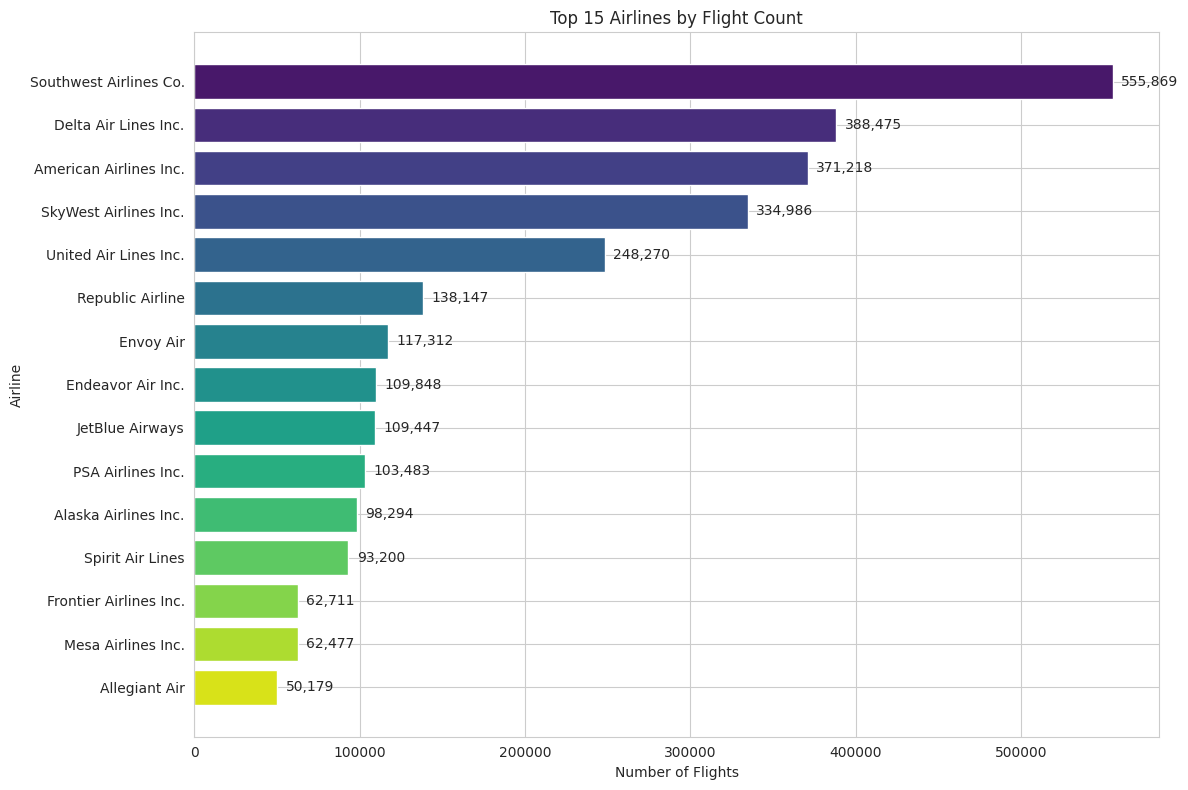

In [8]:
# Query airline frequency
airline_dist = con.execute("""
    SELECT
        AIRLINE,
        COUNT(*) as flight_count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM flights_clean
    GROUP BY AIRLINE
    ORDER BY flight_count DESC
""").fetchdf()

print("Top 10 Airlines by Flight Count:")
display(airline_dist.head(10))

# Visualize
plt.figure(figsize=(12, 8))
top_15 = airline_dist.head(15)
plt.barh(top_15['AIRLINE'], top_15['flight_count'], color=sns.color_palette('viridis', 15))
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.title('Top 15 Airlines by Flight Count')
plt.gca().invert_yaxis()

# Add count labels
for i, (airline, count) in enumerate(zip(top_15['AIRLINE'], top_15['flight_count'])):
    plt.text(count + 5000, i, f'{count:,}', va='center')

plt.tight_layout()
plt.show()

### 6.2 Top Destinations

Top 20 Destination Airports:


,DEST,DEST_CITY,total_flights,delayed_flights,delay_rate
0,ATL,"Atlanta, GA",150750,24415.0,16.20
1,DFW,"Dallas/Fort Worth, TX",125047,27943.0,22.35
2,ORD,"Chicago, IL",119107,24920.0,20.92
3,DEN,"Denver, CO",115866,25409.0,21.93
4,CLT,"Charlotte, NC",92752,16425.0,17.71
5,LAX,"Los Angeles, CA",83924,17256.0,20.56
6,PHX,"Phoenix, AZ",73830,14927.0,20.22
7,LAS,"Las Vegas, NV",71335,17501.0,24.53
8,SEA,"Seattle, WA",69502,13443.0,19.34
9,MCO,"Orlando, FL",61789,15929.0,25.78


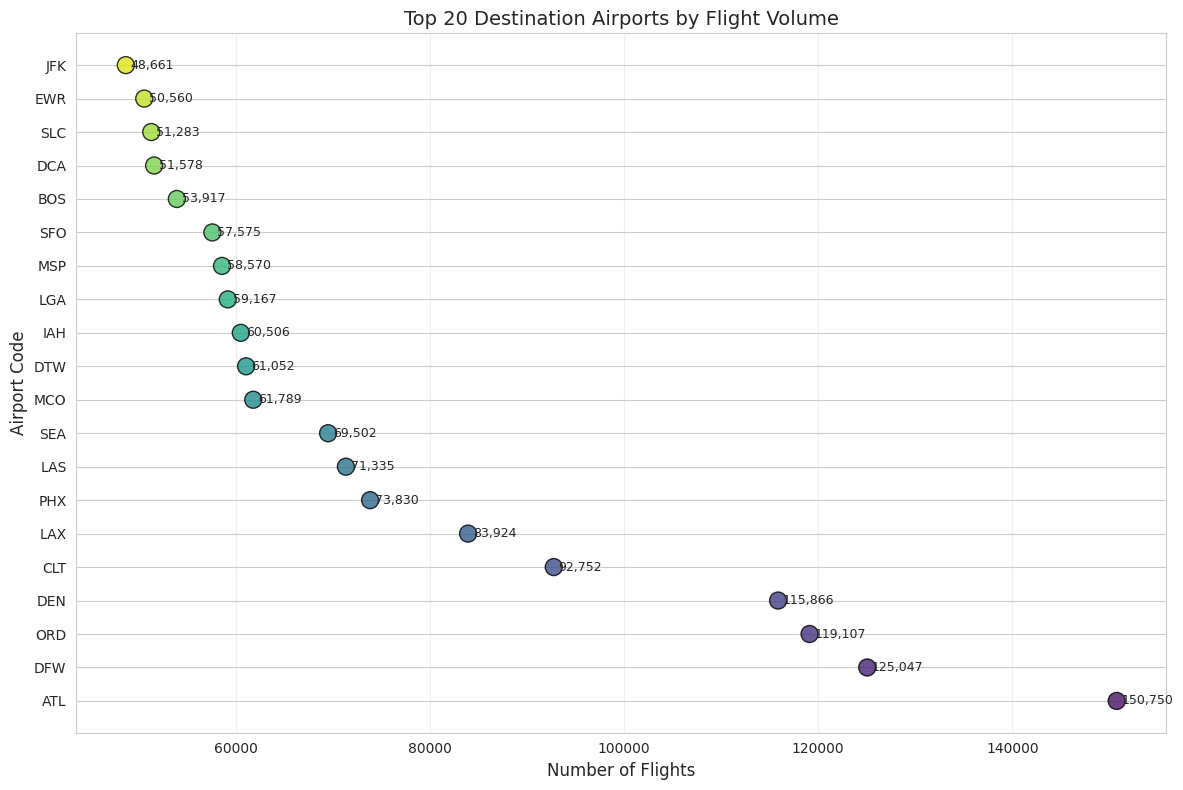

In [9]:
# Query destination popularity
dest_analysis = con.execute("""
    SELECT
        DEST,
        DEST_CITY,
        COUNT(*) as total_flights,
        SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) as delayed_flights,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate
    FROM flights_clean
    GROUP BY DEST, DEST_CITY
    ORDER BY total_flights DESC
    LIMIT 20
""").fetchdf()

print("Top 20 Destination Airports:")
display(dest_analysis)

# Dot plot visualization
plt.figure(figsize=(12, 8))
colors = sns.color_palette('viridis', len(dest_analysis))

plt.scatter(
    dest_analysis['total_flights'],
    dest_analysis['DEST'],
    s=150,
    color=colors,
    edgecolors='black',
    alpha=0.8
)

# Add labels
for i, (dest, count) in enumerate(zip(dest_analysis['DEST'], dest_analysis['total_flights'])):
    plt.text(count + 500, i, f'{count:,}', va='center', fontsize=9)

plt.xlabel('Number of Flights', fontsize=12)
plt.ylabel('Airport Code', fontsize=12)
plt.title('Top 20 Destination Airports by Flight Volume', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Delay Rate by Day of Week

Delay Patterns by Day of Week:


,DAY_OF_WEEK,day_name,total_flights,delayed_flights,delay_rate,avg_delay_min
0,1,Sunday,433620,93281.0,21.51,4.72
1,2,Monday,405404,76171.0,18.79,1.69
2,3,Tuesday,410428,81145.0,19.77,2.63
3,4,Wednesday,433179,98009.0,22.63,5.56
4,5,Thursday,433640,100658.0,23.21,5.95
5,6,Friday,373691,76125.0,20.37,3.67


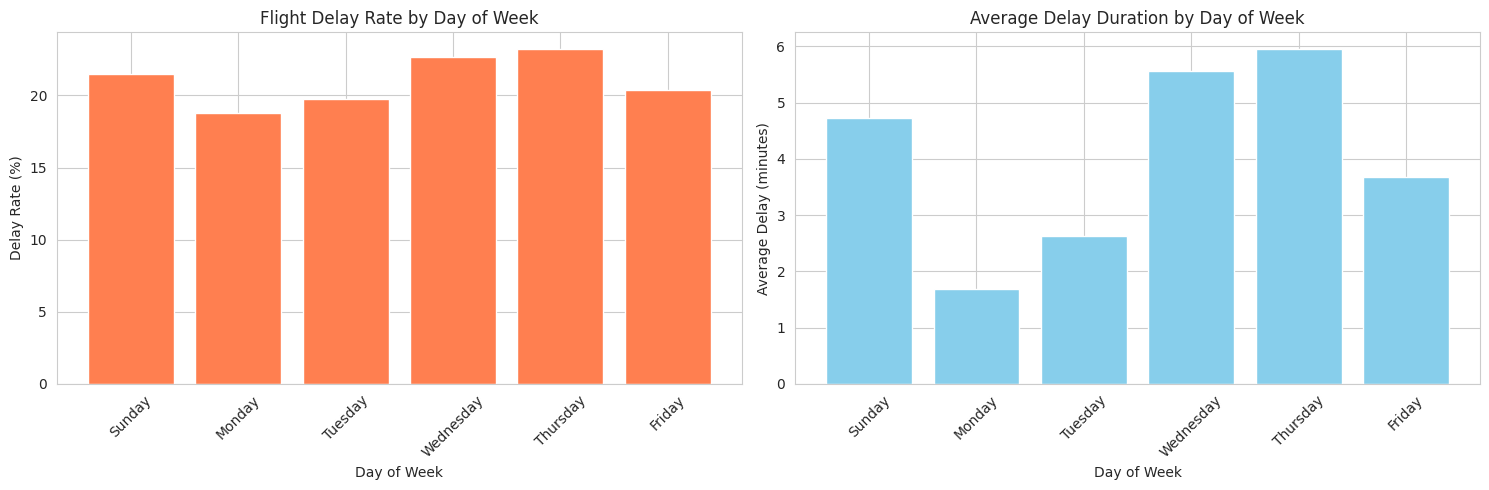

In [10]:
# Analyze delays by day of week
dow_analysis = con.execute("""
    SELECT
        DAY_OF_WEEK,
        CASE DAY_OF_WEEK
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday'
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
            ELSE 'Invalid Day' -- Fallback for any unexpected values
        END as day_name,
        COUNT(*) as total_flights,
        SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) as delayed_flights,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min
    FROM flights_clean
    WHERE DAY_OF_WEEK BETWEEN 1 AND 7 -- Filter out any DAY_OF_WEEK values outside the 1-7 range
    GROUP BY DAY_OF_WEEK
    ORDER BY DAY_OF_WEEK
""").fetchdf()

print("Delay Patterns by Day of Week:")
display(dow_analysis)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Delay rate
ax1.bar(dow_analysis['day_name'], dow_analysis['delay_rate'], color='coral')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Delay Rate (%)')
ax1.set_title('Flight Delay Rate by Day of Week')
ax1.tick_params(axis='x', rotation=45)

# Average delay
ax2.bar(dow_analysis['day_name'], dow_analysis['avg_delay_min'], color='skyblue')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Delay (minutes)')
ax2.set_title('Average Delay Duration by Day of Week')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Time-Based Analysis (SQL)

### 7.1 Average Arrival Delay by Airline

Average Arrival Delay by Airline (Delayed Flights Only):


,AIRLINE,flight_count,avg_delay_min,min_delay_min,max_delay_min,median_delay_min
0,Hawaiian Airlines Inc.,12884,22.1,1.0,1642.0,11.0
1,Horizon Air,7074,24.8,1.0,757.0,11.0
2,Alaska Airlines Inc.,35856,28.3,1.0,805.0,14.0
3,Southwest Airlines Co.,201632,30.2,1.0,697.0,16.0
4,Envoy Air,39295,35.2,1.0,1540.0,15.0
5,Delta Air Lines Inc.,111634,37.3,1.0,1241.0,15.0
6,PSA Airlines Inc.,33956,39.6,1.0,1888.0,16.0
7,Republic Airline,39710,40.3,1.0,1263.0,17.0
8,United Air Lines Inc.,84492,42.6,1.0,1458.0,18.0
9,Spirit Air Lines,35292,43.0,1.0,1294.0,20.0


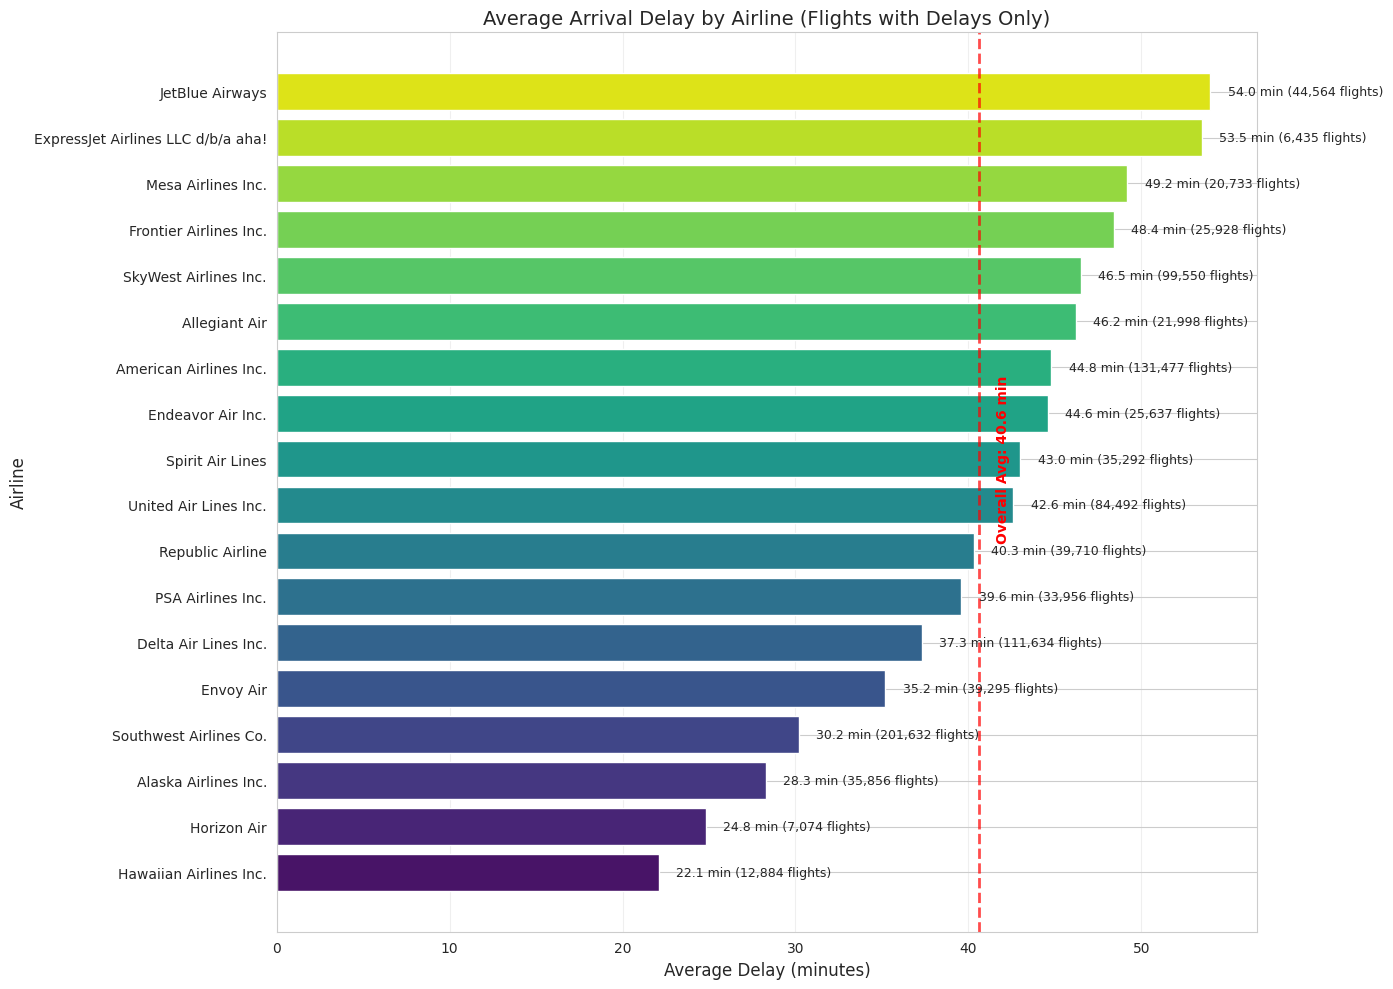


 Key Insights:
 Best: Hawaiian Airlines Inc. - 22.1 min average delay
 Worst: JetBlue Airways - 54.0 min average delay
 Total delayed flights analyzed: 978,147


In [11]:
# Query average delays by airline (only delayed flights)
airline_delays = con.execute("""
    SELECT
        AIRLINE,
        COUNT(*) as flight_count,
        ROUND(AVG(ARR_DELAY), 1) as avg_delay_min,
        ROUND(MIN(ARR_DELAY), 1) as min_delay_min,
        ROUND(MAX(ARR_DELAY), 1) as max_delay_min,
        ROUND(MEDIAN(ARR_DELAY), 1) as median_delay_min
    FROM flights_clean
    WHERE ARR_DELAY > 0  -- Only delayed flights
    GROUP BY AIRLINE
    HAVING COUNT(*) >= 100  -- Minimum sample size
    ORDER BY avg_delay_min ASC
""").fetchdf()

print("Average Arrival Delay by Airline (Delayed Flights Only):")
display(airline_delays)

# Visualize
plt.figure(figsize=(14, 10))
colors = sns.color_palette('viridis', len(airline_delays))

plt.barh(airline_delays['AIRLINE'], airline_delays['avg_delay_min'], color=colors)

# Add annotations
for i, (airline, delay, count) in enumerate(zip(
    airline_delays['AIRLINE'],
    airline_delays['avg_delay_min'],
    airline_delays['flight_count']
)):
    plt.text(delay + 1, i, f'{delay:.1f} min ({count:,} flights)', va='center', fontsize=9)

# Add overall average line
overall_avg = airline_delays['avg_delay_min'].mean()
plt.axvline(overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(overall_avg + 1, len(airline_delays)/2, f'Overall Avg: {overall_avg:.1f} min',
         rotation=90, va='center', color='red', fontweight='bold')

plt.xlabel('Average Delay (minutes)', fontsize=12)
plt.ylabel('Airline', fontsize=12)
plt.title('Average Arrival Delay by Airline (Flights with Delays Only)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print insights
best = airline_delays.iloc[0]
worst = airline_delays.iloc[-1]
print(f"\n Key Insights:")
print(f" Best: {best['AIRLINE']} - {best['avg_delay_min']:.1f} min average delay")
print(f" Worst: {worst['AIRLINE']} - {worst['avg_delay_min']:.1f} min average delay")
print(f" Total delayed flights analyzed: {airline_delays['flight_count'].sum():,}")

### 7.2 Total Delays by Year

Annual Delay Statistics:


,YEAR,total_flights,delayed_flights,delay_rate,total_delay_min,avg_delay_min
0,2019,742096,163409.0,22.02,3939843.0,5.31
1,2020,449823,53320.0,11.85,-2253755.0,-5.01
2,2021,599709,121214.0,20.21,1857235.0,3.10
3,2022,667761,161960.0,24.25,4616091.0,6.91
4,2023,454413,120036.0,26.42,4255883.0,9.37


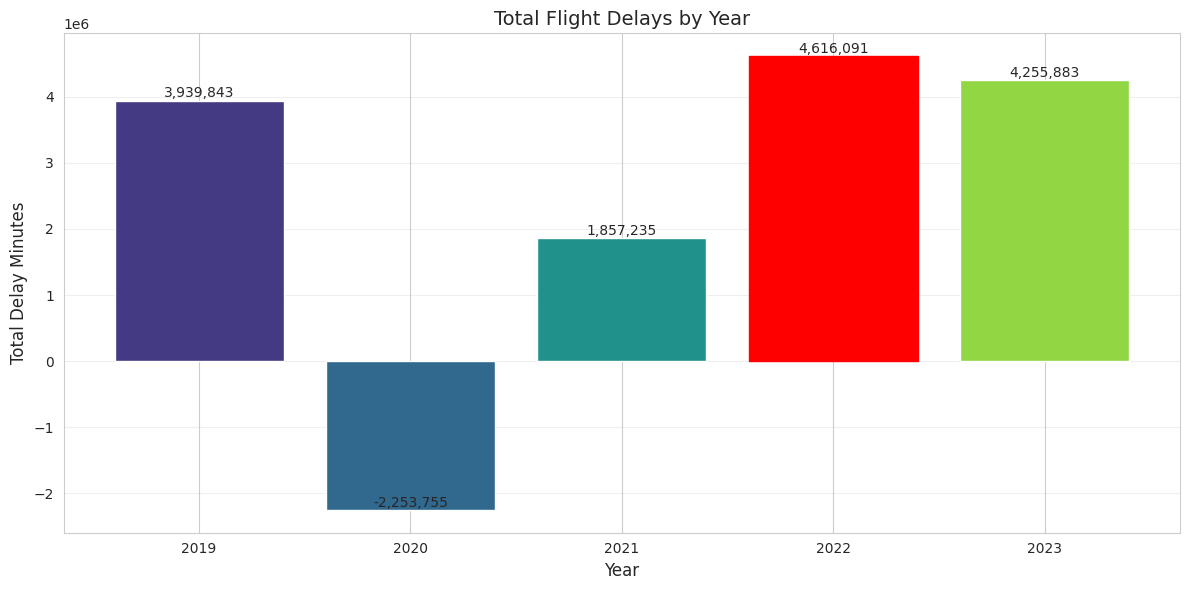


 Peak delay year: 2022 with 4,616,091 total minutes


In [12]:
# Query yearly delay totals
yearly_delays = con.execute("""
    SELECT
        YEAR,
        COUNT(*) as total_flights,
        SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) as delayed_flights,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate,
        ROUND(SUM(ARR_DELAY), 0) as total_delay_min,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min
    FROM flights_clean
    GROUP BY YEAR
    ORDER BY YEAR
""").fetchdf()

print("Annual Delay Statistics:")
display(yearly_delays)

# Visualize total delays
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_delays['YEAR'], yearly_delays['total_delay_min'],
               color=sns.color_palette('viridis', len(yearly_delays)))

# Highlight max year
max_idx = yearly_delays['total_delay_min'].idxmax()
bars[max_idx].set_color('red')

# Add value labels
for i, (year, delay) in enumerate(zip(yearly_delays['YEAR'], yearly_delays['total_delay_min'])):
    plt.text(year, delay + 50000, f'{delay:,.0f}', ha='center', fontsize=10)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.title(f'Total Flight Delays by Year', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

max_year = yearly_delays.loc[max_idx, 'YEAR']
max_delay = yearly_delays.loc[max_idx, 'total_delay_min']
print(f"\n Peak delay year: {max_year} with {max_delay:,.0f} total minutes")

### 7.3 Monthly Delay Trends

Monthly Delay Trends by Year:


,YEAR,MONTH,total_flights,total_delay_min,avg_delay_min
0,2019,1,57605,235682.0,4.09
1,2019,2,52823,477145.0,9.03
2,2019,3,63474,209357.0,3.30
3,2019,4,60440,275808.0,4.56
4,2019,5,63387,414630.0,6.54
5,2019,6,63270,745941.0,11.79
6,2019,7,65620,547324.0,8.34
7,2019,8,66158,508007.0,7.68
8,2019,9,60897,3533.0,0.06
9,2019,10,64250,150579.0,2.34


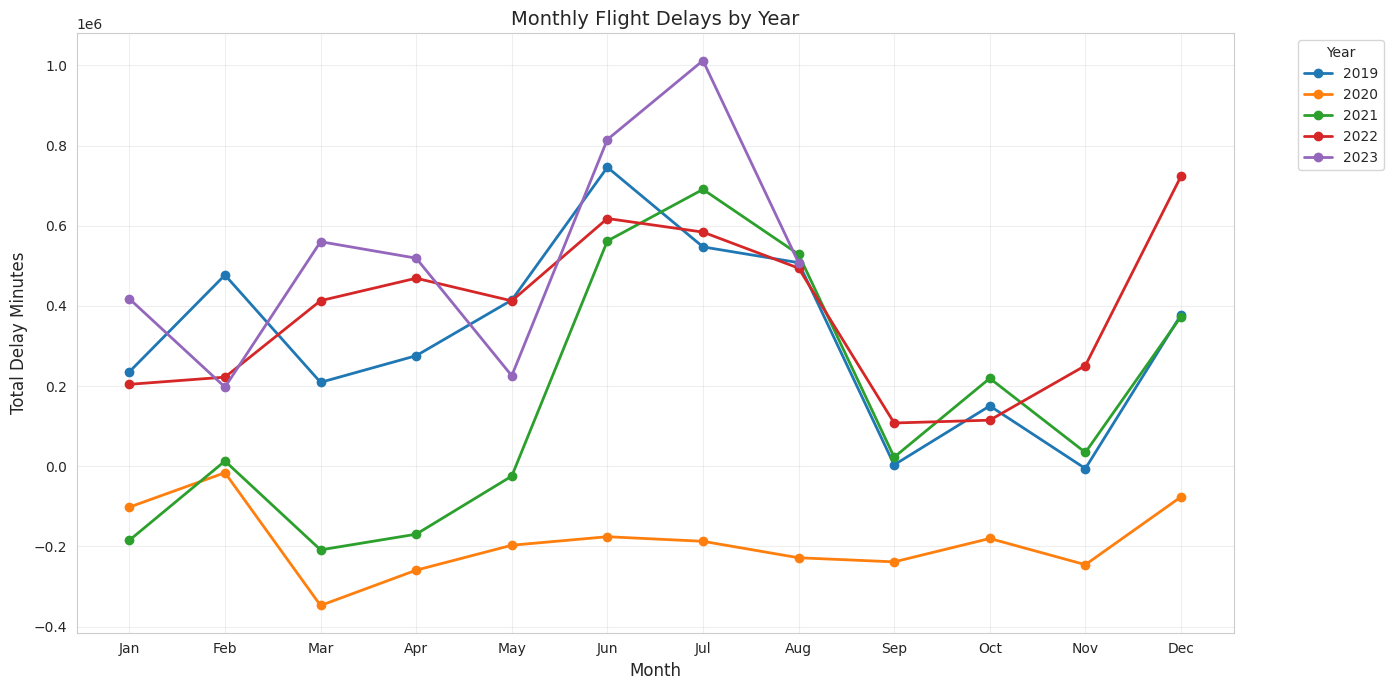

In [13]:
monthly_delays = con.execute("""
    SELECT
        YEAR,
        MONTH,
        COUNT(*) as total_flights,
        ROUND(SUM(ARR_DELAY), 0) as total_delay_min,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min
    FROM flights_clean
    GROUP BY YEAR, MONTH
    ORDER BY YEAR, MONTH
""").fetchdf()

# Pivot for better visualization
monthly_pivot = monthly_delays.pivot(index='MONTH', columns='YEAR', values='total_delay_min')

print("Monthly Delay Trends by Year:")
display(monthly_delays.head(12))

# Line plot
plt.figure(figsize=(14, 7))
for year in monthly_delays['YEAR'].unique():
    year_data = monthly_delays[monthly_delays['YEAR'] == year]
    plt.plot(year_data['MONTH'], year_data['total_delay_min'],
             marker='o', linewidth=2, label=str(year))

plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.title('Monthly Flight Delays by Year', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.4 COVID-19 Impact Analysis

Year with minimum delays: 2020 (-2,253,755 minutes)
This reflects the COVID-19 pandemic impact on air travel


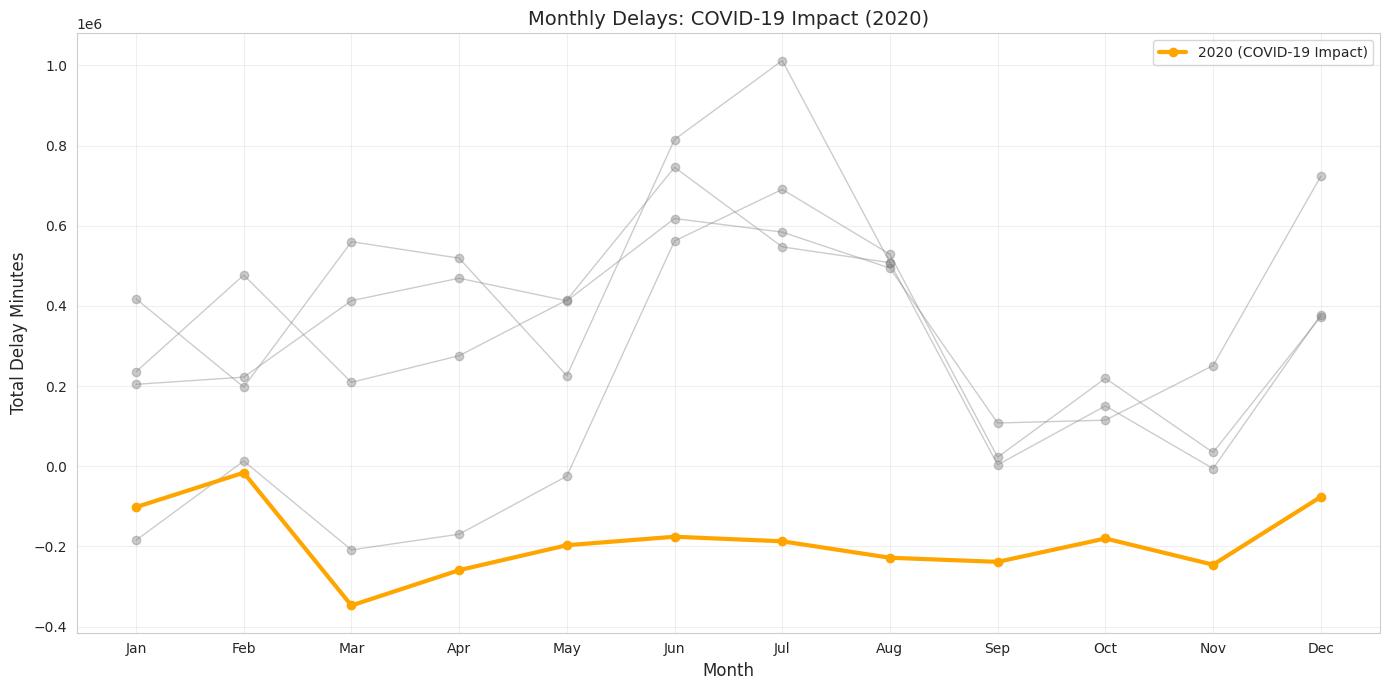

In [14]:
# Identify minimum delay year
min_year_data = con.execute("""
    SELECT
        YEAR,
        SUM(ARR_DELAY) as total_delay
    FROM flights_clean
    GROUP BY YEAR
    ORDER BY total_delay ASC
    LIMIT 1
""").fetchdf()

min_year = min_year_data['YEAR'][0]
min_delay = min_year_data['total_delay'][0]

print(f"Year with minimum delays: {min_year} ({min_delay:,.0f} minutes)")
print("This reflects the COVID-19 pandemic impact on air travel")

# Plot with 2020 highlighted
plt.figure(figsize=(14, 7))

# Plot all years in gray
for year in monthly_delays['YEAR'].unique():
    year_data = monthly_delays[monthly_delays['YEAR'] == year]
    if year == min_year:
        plt.plot(year_data['MONTH'], year_data['total_delay_min'],
                marker='o', linewidth=3, label=f'{year} (COVID-19 Impact)',
                color='orange', zorder=10)
    else:
        plt.plot(year_data['MONTH'], year_data['total_delay_min'],
                marker='o', linewidth=1, alpha=0.4, color='gray')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.title(f'Monthly Delays: COVID-19 Impact ({min_year})', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Delay Cause Analysis (SQL)

### 8.1 Aggregate Delay Reasons

Delay Cause Analysis:
------------------------------------------------------------
Late Aircraft       :   13,598,175 min ( 37.7%)
Carrier             :   13,217,960 min ( 36.7%)
NAS                 :    7,028,161 min ( 19.5%)
Weather             :    2,127,583 min (  5.9%)
Security            :       77,907 min (  0.2%)
------------------------------------------------------------
Total               :   36,049,786 min


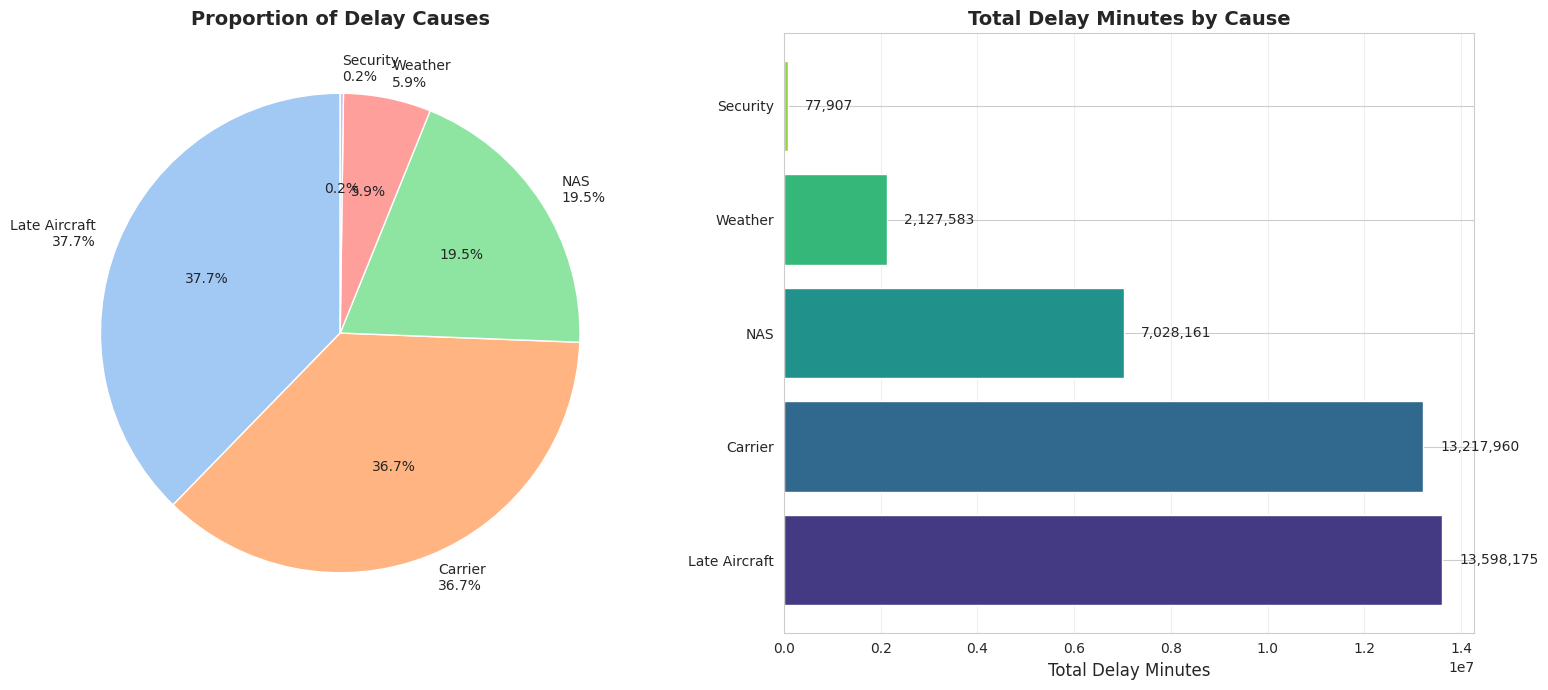


 Primary delay cause: Late Aircraft (37.7% of all delays)


In [15]:
# Analyze delay causes
delay_cause_summary = con.execute("""
    SELECT
        ROUND(SUM(DELAY_DUE_CARRIER), 0) as carrier_delay,
        ROUND(SUM(DELAY_DUE_WEATHER), 0) as weather_delay,
        ROUND(SUM(DELAY_DUE_NAS), 0) as nas_delay,
        ROUND(SUM(DELAY_DUE_SECURITY), 0) as security_delay,
        ROUND(SUM(DELAY_DUE_LATE_AIRCRAFT), 0) as late_aircraft_delay
    FROM delay_reasons
""").fetchdf()

# Convert to long format for visualization
delay_causes = {
    'Late Aircraft': delay_cause_summary['late_aircraft_delay'][0],
    'Carrier': delay_cause_summary['carrier_delay'][0],
    'NAS': delay_cause_summary['nas_delay'][0],
    'Weather': delay_cause_summary['weather_delay'][0],
    'Security': delay_cause_summary['security_delay'][0]
}

# Calculate percentages
total_delay = sum(delay_causes.values())
delay_pct = {k: (v / total_delay) * 100 for k, v in delay_causes.items()}

print("Delay Cause Analysis:")
print("-" * 60)
for cause, minutes in sorted(delay_causes.items(), key=lambda x: x[1], reverse=True):
    print(f"{cause:<20}: {minutes:>12,.0f} min ({delay_pct[cause]:>5.1f}%)")
print("-" * 60)
print(f"{'Total':<20}: {total_delay:>12,.0f} min")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Pie chart
colors_pie = sns.color_palette('pastel', len(delay_causes))
wedges, texts, autotexts = ax1.pie(
    delay_causes.values(),
    labels=[f"{k}\n{delay_pct[k]:.1f}%" for k in delay_causes.keys()],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie
)
ax1.set_title('Proportion of Delay Causes', fontsize=14, fontweight='bold')

# Bar chart
sorted_causes = dict(sorted(delay_causes.items(), key=lambda x: x[1], reverse=True))
bars = ax2.barh(list(sorted_causes.keys()), list(sorted_causes.values()),
                color=sns.color_palette('viridis', len(sorted_causes)))
ax2.set_xlabel('Total Delay Minutes', fontsize=12)
ax2.set_title('Total Delay Minutes by Cause', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cause, minutes) in enumerate(sorted_causes.items()):
    ax2.text(minutes + total_delay * 0.01, i, f'{minutes:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Key insight
primary = max(delay_pct, key=delay_pct.get)
print(f"\n Primary delay cause: {primary} ({delay_pct[primary]:.1f}% of all delays)")

### 8.2 Delay Causes by Year

Delay Causes by Year:


,year,carrier,weather,nas,security,late_aircraft
0,2019,2937415.0,543705.0,2355203.0,13825.0,3855709.0
1,2020,1147914.0,190881.0,599946.0,6914.0,789000.0
2,2021,2774268.0,477748.0,1137820.0,22426.0,2381419.0
3,2022,3736174.0,504925.0,1577937.0,19277.0,3557967.0
4,2023,2622189.0,410324.0,1357255.0,15465.0,3014080.0


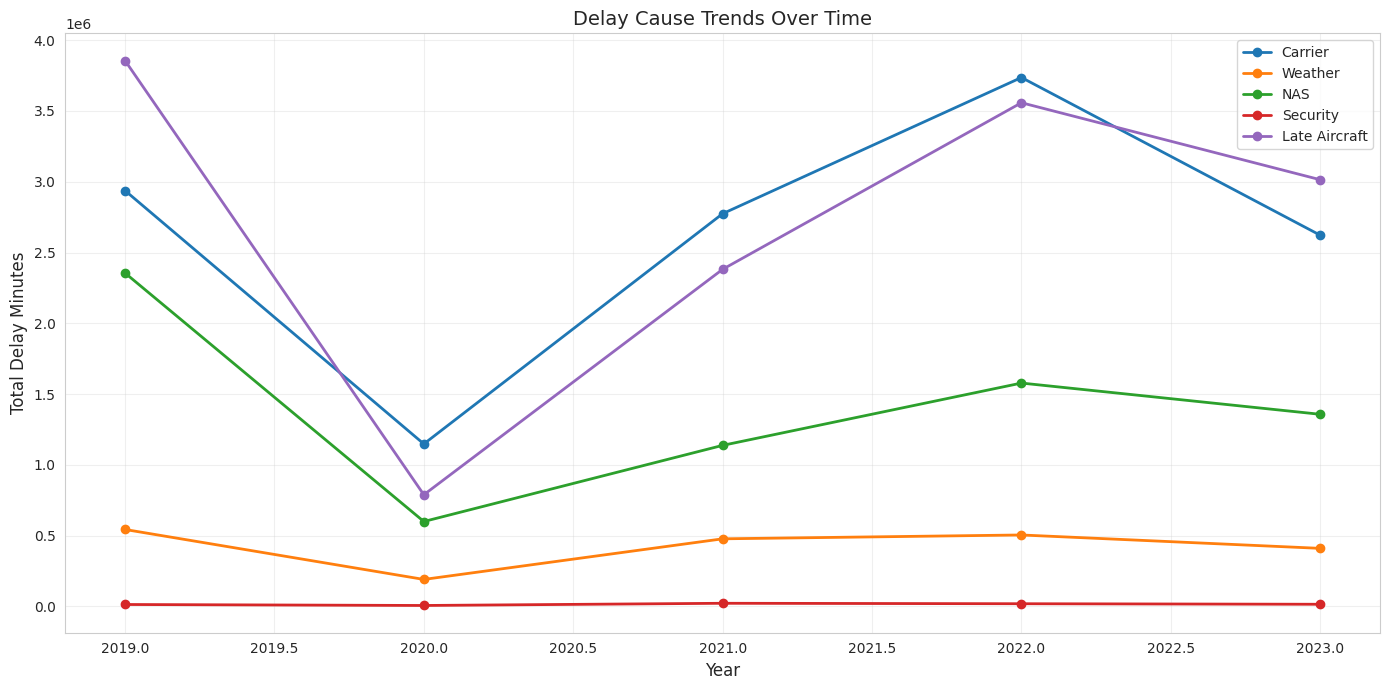

In [16]:
# Much better approach - add row numbers to match rows correctly
yearly_causes = con.execute(f"""
    WITH raw_with_delays AS (
        SELECT
            YEAR(CAST(FL_DATE AS DATE)) as year,
            DELAY_DUE_CARRIER,
            DELAY_DUE_WEATHER,
            DELAY_DUE_NAS,
            DELAY_DUE_SECURITY,
            DELAY_DUE_LATE_AIRCRAFT
        FROM read_csv_auto('{csv_file_path}')
        WHERE YEAR(CAST(FL_DATE AS DATE)) IS NOT NULL
    )
    SELECT
        year,
        ROUND(SUM(COALESCE(DELAY_DUE_CARRIER, 0)), 0) as carrier,
        ROUND(SUM(COALESCE(DELAY_DUE_WEATHER, 0)), 0) as weather,
        ROUND(SUM(COALESCE(DELAY_DUE_NAS, 0)), 0) as nas,
        ROUND(SUM(COALESCE(DELAY_DUE_SECURITY, 0)), 0) as security,
        ROUND(SUM(COALESCE(DELAY_DUE_LATE_AIRCRAFT, 0)), 0) as late_aircraft
    FROM raw_with_delays
    GROUP BY year
    ORDER BY year
""").fetchdf()

print("Delay Causes by Year:")
display(yearly_causes)

# Plot trends
plt.figure(figsize=(14, 7))
plt.plot(yearly_causes['year'], yearly_causes['carrier'], marker='o', label='Carrier', linewidth=2)
plt.plot(yearly_causes['year'], yearly_causes['weather'], marker='o', label='Weather', linewidth=2)
plt.plot(yearly_causes['year'], yearly_causes['nas'], marker='o', label='NAS', linewidth=2)
plt.plot(yearly_causes['year'], yearly_causes['security'], marker='o', label='Security', linewidth=2)
plt.plot(yearly_causes['year'], yearly_causes['late_aircraft'], marker='o', label='Late Aircraft', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.title('Delay Cause Trends Over Time', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Advanced SQL Queries

### 9.1 Most Problematic Routes

Top 20 Most Problematic Routes (by delay rate):


,route,cities,total_flights,delayed_flights,delay_rate,avg_delay_min,avg_distance
0,BOS → SJU,"Boston, MA → San Juan, PR",589,215.0,36.50,15.62,1674.0
1,SJU → EWR,"San Juan, PR → Newark, NJ",926,335.0,36.18,18.21,1608.0
2,EWR → SJU,"Newark, NJ → San Juan, PR",895,315.0,35.20,16.49,1608.0
3,MCO → SJU,"Orlando, FL → San Juan, PR",2576,877.0,34.05,16.09,1189.0
4,MCO → EWR,"Orlando, FL → Newark, NJ",2754,934.0,33.91,18.15,937.0
5,DFW → SMF,"Dallas/Fort Worth, TX → Sacramento, CA",717,243.0,33.89,13.58,1431.0
6,SJU → BOS,"San Juan, PR → Boston, MA",633,210.0,33.18,7.88,1674.0
7,HPN → PBI,"White Plains, NY → West Palm Beach/Palm Beach, FL",569,188.0,33.04,14.07,1056.0
8,MIA → LAX,"Miami, FL → Los Angeles, CA",1196,390.0,32.61,13.49,2342.0
9,EWR → PBI,"Newark, NJ → West Palm Beach/Palm Beach, FL",1259,410.0,32.57,11.06,1023.0


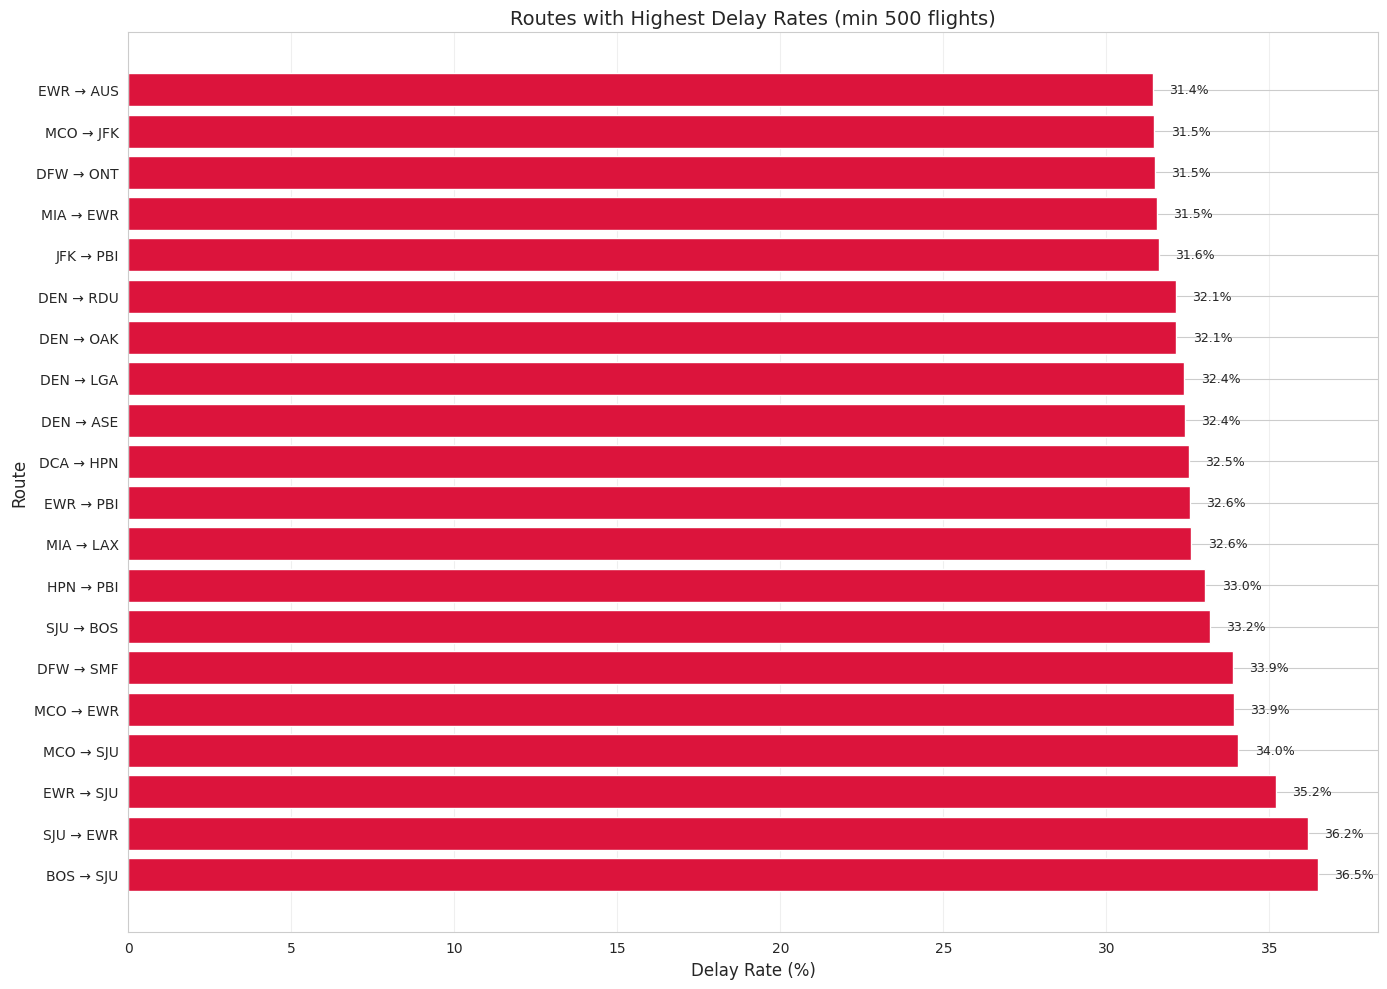

In [17]:
# Identify routes with highest delay rates
problematic_routes = con.execute("""
    SELECT
        ORIGIN || ' → ' || DEST as route,
        ORIGIN_CITY || ' → ' || DEST_CITY as cities,
        COUNT(*) as total_flights,
        SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) as delayed_flights,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min,
        ROUND(AVG(DISTANCE), 0) as avg_distance
    FROM flights_clean
    GROUP BY ORIGIN, DEST, ORIGIN_CITY, DEST_CITY
    HAVING COUNT(*) >= 500  -- Minimum flights for statistical significance
    ORDER BY delay_rate DESC
    LIMIT 20
""").fetchdf()

print("Top 20 Most Problematic Routes (by delay rate):")
display(problematic_routes)

# Visualize
plt.figure(figsize=(14, 10))
plt.barh(problematic_routes['route'], problematic_routes['delay_rate'], color='crimson')
plt.xlabel('Delay Rate (%)', fontsize=12)
plt.ylabel('Route', fontsize=12)
plt.title('Routes with Highest Delay Rates (min 500 flights)', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add labels
for i, (route, rate) in enumerate(zip(problematic_routes['route'], problematic_routes['delay_rate'])):
    plt.text(rate + 0.5, i, f'{rate:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 9.2 Distance vs Delay Correlation

Delay Patterns by Flight Distance:


,distance_range,total_flights,avg_delay_min,delay_rate
0,< 500 mi,1053037,3.34,19.26
1,500-1000 mi,1052773,4.82,21.63
2,1000-1500 mi,453995,5.88,23.89
3,1500-2000 mi,185862,4.22,23.14
4,> 2000 mi,168135,2.21,22.60


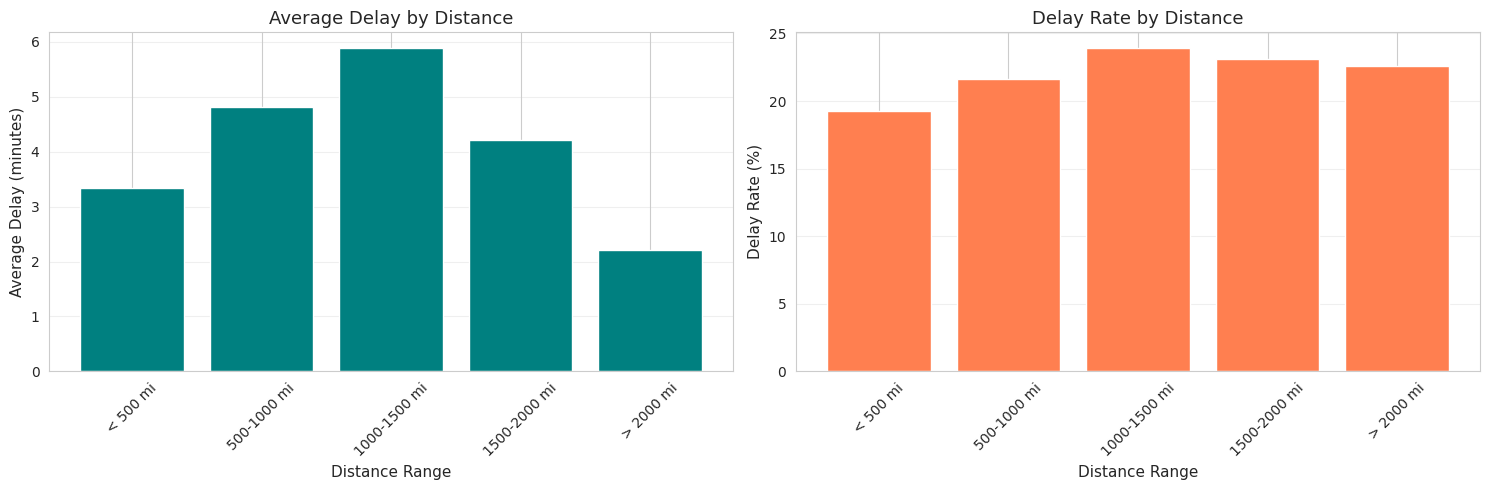

In [18]:
# Analyze relationship between distance and delays
distance_analysis = con.execute("""
    SELECT
        CASE
            WHEN DISTANCE < 500 THEN '< 500 mi'
            WHEN DISTANCE < 1000 THEN '500-1000 mi'
            WHEN DISTANCE < 1500 THEN '1000-1500 mi'
            WHEN DISTANCE < 2000 THEN '1500-2000 mi'
            ELSE '> 2000 mi'
        END as distance_range,
        COUNT(*) as total_flights,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate
    FROM flights_clean
    GROUP BY distance_range
    ORDER BY
        CASE distance_range
            WHEN '< 500 mi' THEN 1
            WHEN '500-1000 mi' THEN 2
            WHEN '1000-1500 mi' THEN 3
            WHEN '1500-2000 mi' THEN 4
            ELSE 5
        END
""").fetchdf()

print("Delay Patterns by Flight Distance:")
display(distance_analysis)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(distance_analysis['distance_range'], distance_analysis['avg_delay_min'], color='teal')
ax1.set_xlabel('Distance Range', fontsize=11)
ax1.set_ylabel('Average Delay (minutes)', fontsize=11)
ax1.set_title('Average Delay by Distance', fontsize=13)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(distance_analysis['distance_range'], distance_analysis['delay_rate'], color='coral')
ax2.set_xlabel('Distance Range', fontsize=11)
ax2.set_ylabel('Delay Rate (%)', fontsize=11)
ax2.set_title('Delay Rate by Distance', fontsize=13)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 9.3 Peak Hour Analysis

Delay Patterns by Departure Hour:


,departure_hour,total_flights,avg_delay_min,delay_rate
0,0,3918,1.47,19.73
1,1,3268,3.25,21.11
2,2,928,11.41,26.72
3,3,559,12.09,28.44
4,4,398,9.87,25.63
5,5,53422,-2.96,10.27
6,6,203348,-2.49,11.60
7,7,189761,-1.75,13.71
8,8,203282,-1.16,15.29
9,9,160743,-0.59,16.38


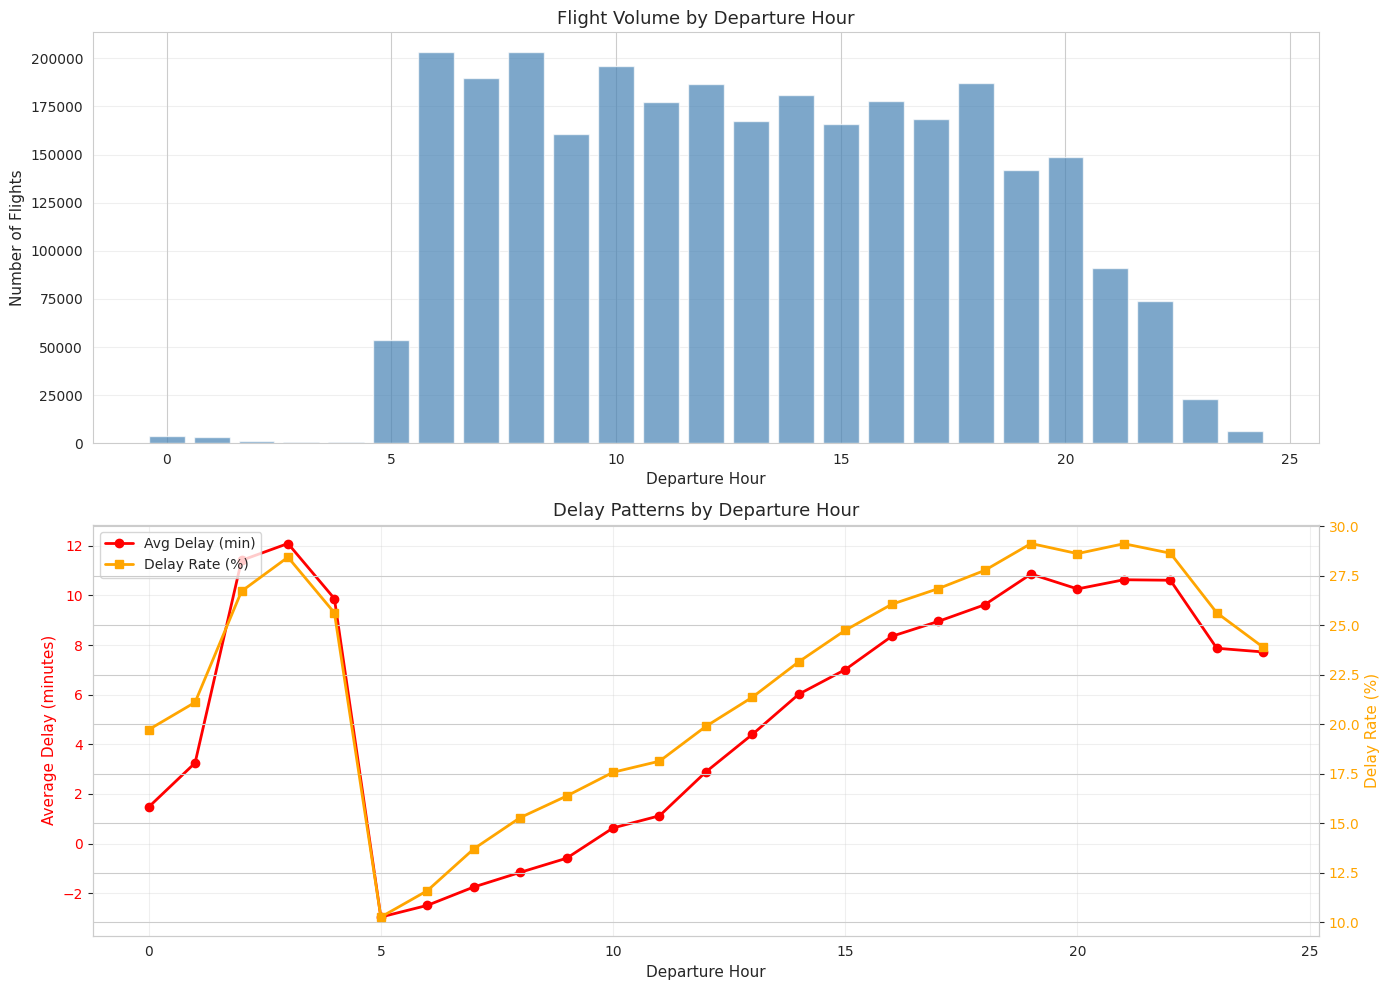


⏰ Peak delay hour: 3:00 with 12.1 min average delay


In [19]:
# Analyze delays by departure time
# Convert time integers to hour of day
hourly_analysis = con.execute("""
    SELECT
        CAST(CRS_DEP_TIME / 100 AS INTEGER) as departure_hour,
        COUNT(*) as total_flights,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate
    FROM flights_clean
    WHERE CRS_DEP_TIME IS NOT NULL
    GROUP BY departure_hour
    ORDER BY departure_hour
""").fetchdf()

print("Delay Patterns by Departure Hour:")
display(hourly_analysis)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Flight volume
ax1.bar(hourly_analysis['departure_hour'], hourly_analysis['total_flights'],
        color='steelblue', alpha=0.7)
ax1.set_xlabel('Departure Hour', fontsize=11)
ax1.set_ylabel('Number of Flights', fontsize=11)
ax1.set_title('Flight Volume by Departure Hour', fontsize=13)
ax1.grid(axis='y', alpha=0.3)

# Delay metrics
ax2_twin = ax2.twinx()
line1 = ax2.plot(hourly_analysis['departure_hour'], hourly_analysis['avg_delay_min'],
                 marker='o', color='red', linewidth=2, label='Avg Delay (min)')
line2 = ax2_twin.plot(hourly_analysis['departure_hour'], hourly_analysis['delay_rate'],
                      marker='s', color='orange', linewidth=2, label='Delay Rate (%)')

ax2.set_xlabel('Departure Hour', fontsize=11)
ax2.set_ylabel('Average Delay (minutes)', fontsize=11, color='red')
ax2_twin.set_ylabel('Delay Rate (%)', fontsize=11, color='orange')
ax2.set_title('Delay Patterns by Departure Hour', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

# Identify peak delay hours
peak_hour = hourly_analysis.loc[hourly_analysis['avg_delay_min'].idxmax(), 'departure_hour']
print(f"\n⏰ Peak delay hour: {peak_hour}:00 with {hourly_analysis.loc[hourly_analysis['avg_delay_min'].idxmax(), 'avg_delay_min']:.1f} min average delay")

### 9.4 Seasonal Analysis

Seasonal Delay Patterns:


,QUARTER,quarter_name,total_flights,avg_delay_min,delay_rate
0,1,Q1 (Jan-Mar),779386,2.68,20.40
1,2,Q2 (Apr-Jun),738518,5.73,22.56
2,3,Q3 (Jul-Sep),763395,5.70,21.95
3,4,Q4 (Oct-Dec),632503,2.75,20.04


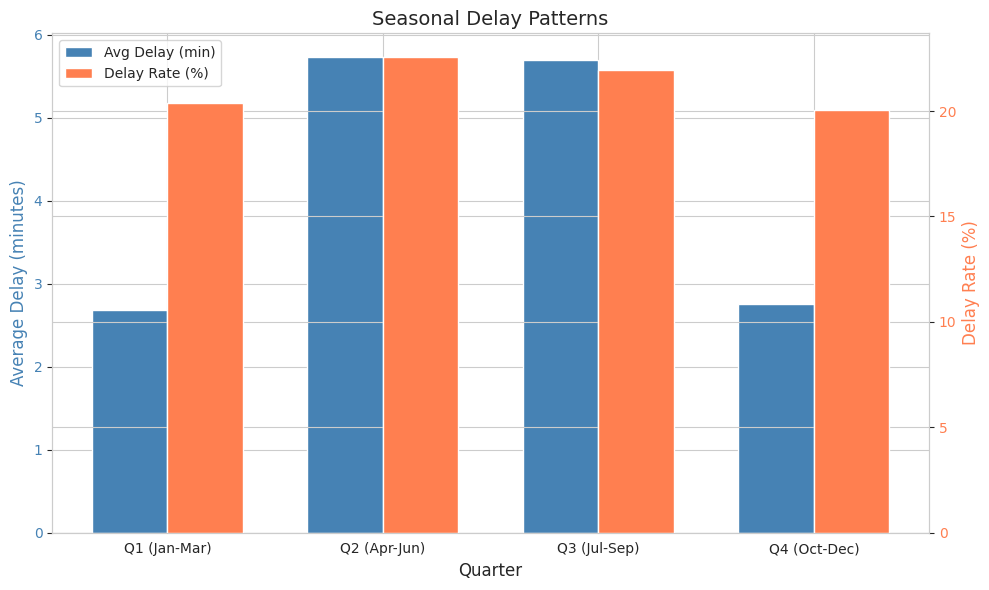

In [20]:
# Analyze delays by quarter
quarterly_analysis = con.execute("""
    SELECT
        QUARTER,
        CASE QUARTER
            WHEN 1 THEN 'Q1 (Jan-Mar)'
            WHEN 2 THEN 'Q2 (Apr-Jun)'
            WHEN 3 THEN 'Q3 (Jul-Sep)'
            WHEN 4 THEN 'Q4 (Oct-Dec)'
        END as quarter_name,
        COUNT(*) as total_flights,
        ROUND(AVG(ARR_DELAY), 2) as avg_delay_min,
        ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as delay_rate
    FROM flights_clean
    GROUP BY QUARTER
    ORDER BY QUARTER
""").fetchdf()

print("Seasonal Delay Patterns:")
display(quarterly_analysis)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(quarterly_analysis))
width = 0.35

bars1 = ax.bar(x - width/2, quarterly_analysis['avg_delay_min'], width,
               label='Avg Delay (min)', color='steelblue')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, quarterly_analysis['delay_rate'], width,
                label='Delay Rate (%)', color='coral')

ax.set_xlabel('Quarter', fontsize=12)
ax.set_ylabel('Average Delay (minutes)', fontsize=12, color='steelblue')
ax2.set_ylabel('Delay Rate (%)', fontsize=12, color='coral')
ax.set_title('Seasonal Delay Patterns', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(quarterly_analysis['quarter_name'])
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

## 10. Classification

### 10.1 Pre-Flight Prediction

In [21]:
# Prepare data - NO departure delay
model_data_preflight = con.execute("""
    SELECT
        -- Airline (Section 7.1: Hawaiian 22min vs JetBlue 54min)
        AIRLINE_CODE,

        -- Route (Section 9.1: routes vary 15-35% delay rates)
        ORIGIN,
        DEST,

        -- Temporal patterns (Section 6.3, 7.3)
        MONTH,
        DAY_OF_WEEK,

        -- Time of day (early flights less delayed)
        CRS_DEP_TIME,

        -- Distance (Section 9.2: medium distance = higher delays)
        DISTANCE,

        -- Engineered features for better performance
        CASE
            WHEN DAY_OF_WEEK IN (1, 7) THEN 1
            ELSE 0
        END as IS_WEEKEND,

        CASE
            WHEN MONTH IN (6, 7, 8) THEN 1  -- Summer peak from Section 7.3
            ELSE 0
        END as IS_SUMMER,

        CASE
            WHEN CRS_DEP_TIME >= 1800 THEN 1  -- Evening flights
            ELSE 0
        END as IS_EVENING,

        -- Target
        IS_DELAYED

    FROM flights_clean
    WHERE DEP_DELAY IS NOT NULL
""").fetchdf()

print(f"\nPre-flight dataset: {len(model_data_preflight):,} records")
print(f"Delay rate: {model_data_preflight['IS_DELAYED'].mean():.1%}")

# Encode categoricals
from sklearn.preprocessing import LabelEncoder

X_preflight = model_data_preflight.drop('IS_DELAYED', axis=1)
y_preflight = model_data_preflight['IS_DELAYED']

for col in ['AIRLINE_CODE', 'ORIGIN', 'DEST']:
    le = LabelEncoder()
    X_preflight[col] = le.fit_transform(X_preflight[col])

# Train-test split
from sklearn.model_selection import train_test_split

X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    X_preflight, y_preflight,
    test_size=0.2,
    random_state=42,
    stratify=y_preflight
)

print(f"Train: {len(X_train_pre):,} | Test: {len(X_test_pre):,}")

# Train models WITHOUT class weighting (better overall performance)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\n--- Training Logistic Regression (Pre-Flight) ---")
lr_pre = LogisticRegression(max_iter=1000, random_state=42)
lr_pre.fit(X_train_pre, y_train_pre)

y_pred_lr_pre = lr_pre.predict(X_test_pre)
y_proba_lr_pre = lr_pre.predict_proba(X_test_pre)[:, 1]

print(classification_report(y_test_pre, y_pred_lr_pre, target_names=['On-Time', 'Delayed']))
print(f"ROC-AUC: {roc_auc_score(y_test_pre, y_proba_lr_pre):.3f}")

print("\n--- Training Random Forest (Pre-Flight) ---")
rf_pre = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=100,
    random_state=42,
    n_jobs=-1
)
rf_pre.fit(X_train_pre, y_train_pre)

y_pred_rf_pre = rf_pre.predict(X_test_pre)
y_proba_rf_pre = rf_pre.predict_proba(X_test_pre)[:, 1]

print(classification_report(y_test_pre, y_pred_rf_pre, target_names=['On-Time', 'Delayed']))
print(f"ROC-AUC: {roc_auc_score(y_test_pre, y_proba_rf_pre):.3f}")



Pre-flight dataset: 2,913,802 records
Delay rate: 21.3%
Train: 2,331,041 | Test: 582,761

--- Training Logistic Regression (Pre-Flight) ---
              precision    recall  f1-score   support

     On-Time       0.79      1.00      0.88    458773
     Delayed       1.00      0.00      0.00    123988

    accuracy                           0.79    582761
   macro avg       0.89      0.50      0.44    582761
weighted avg       0.83      0.79      0.69    582761

ROC-AUC: 0.609

--- Training Random Forest (Pre-Flight) ---
              precision    recall  f1-score   support

     On-Time       0.79      1.00      0.88    458773
     Delayed       0.62      0.01      0.02    123988

    accuracy                           0.79    582761
   macro avg       0.71      0.50      0.45    582761
weighted avg       0.75      0.79      0.70    582761

ROC-AUC: 0.653


### 10.2 Real-Time Prediction

In [22]:
#Prepare data - INCLUDING departure delay
model_data_realtime = con.execute("""
    SELECT
        -- All previous features
        AIRLINE_CODE,
        ORIGIN,
        DEST,
        MONTH,
        DAY_OF_WEEK,
        CRS_DEP_TIME,
        DISTANCE,

        -- Engineered features
        CASE WHEN DAY_OF_WEEK IN (1, 7) THEN 1 ELSE 0 END as IS_WEEKEND,
        CASE WHEN MONTH IN (6, 7, 8) THEN 1 ELSE 0 END as IS_SUMMER,
        CASE WHEN CRS_DEP_TIME >= 1800 THEN 1 ELSE 0 END as IS_EVENING,

        -- THE KEY PREDICTOR: Departure delay
        DEP_DELAY,

        -- Additional real-time features
        TAXI_OUT,  -- How long taxiing took (congestion indicator)

        -- Target
        IS_DELAYED

    FROM flights_clean
    WHERE DEP_DELAY IS NOT NULL
      AND TAXI_OUT IS NOT NULL
""").fetchdf()

print(f"\nReal-time dataset: {len(model_data_realtime):,} records")
print(f"Delay rate: {model_data_realtime['IS_DELAYED'].mean():.1%}")

# Encode categoricals
X_realtime = model_data_realtime.drop('IS_DELAYED', axis=1)
y_realtime = model_data_realtime['IS_DELAYED']

for col in ['AIRLINE_CODE', 'ORIGIN', 'DEST']:
    le = LabelEncoder()
    X_realtime[col] = le.fit_transform(X_realtime[col])

# Train-test split
X_train_rt, X_test_rt, y_train_rt, y_test_rt = train_test_split(
    X_realtime, y_realtime,
    test_size=0.2,
    random_state=42,
    stratify=y_realtime
)

print(f"Train: {len(X_train_rt):,} | Test: {len(X_test_rt):,}")

print("\n--- Training Logistic Regression (Real-Time) ---")
lr_rt = LogisticRegression(max_iter=1000, random_state=42)
lr_rt.fit(X_train_rt, y_train_rt)

y_pred_lr_rt = lr_rt.predict(X_test_rt)
y_proba_lr_rt = lr_rt.predict_proba(X_test_rt)[:, 1]

print(classification_report(y_test_rt, y_pred_lr_rt, target_names=['On-Time', 'Delayed']))
print(f"ROC-AUC: {roc_auc_score(y_test_rt, y_proba_lr_rt):.3f}")

print("\n--- Training Random Forest (Real-Time) ---")
rf_rt = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=100,
    random_state=42,
    n_jobs=-1
)
rf_rt.fit(X_train_rt, y_train_rt)

y_pred_rf_rt = rf_rt.predict(X_test_rt)
y_proba_rf_rt = rf_rt.predict_proba(X_test_rt)[:, 1]

print(classification_report(y_test_rt, y_pred_rf_rt, target_names=['On-Time', 'Delayed']))
print(f"ROC-AUC: {roc_auc_score(y_test_rt, y_proba_rf_rt):.3f}")


Real-time dataset: 2,913,802 records
Delay rate: 21.3%
Train: 2,331,041 | Test: 582,761

--- Training Logistic Regression (Real-Time) ---
              precision    recall  f1-score   support

     On-Time       0.94      0.97      0.96    458773
     Delayed       0.89      0.77      0.82    123988

    accuracy                           0.93    582761
   macro avg       0.92      0.87      0.89    582761
weighted avg       0.93      0.93      0.93    582761

ROC-AUC: 0.947

--- Training Random Forest (Real-Time) ---
              precision    recall  f1-score   support

     On-Time       0.94      0.98      0.96    458773
     Delayed       0.91      0.77      0.83    123988

    accuracy                           0.93    582761
   macro avg       0.92      0.87      0.90    582761
weighted avg       0.93      0.93      0.93    582761

ROC-AUC: 0.956


### 10.3 Model Comparisons

In [23]:
comparison = pd.DataFrame({
    'Model': [
        'Logistic Reg (Pre-Flight)',
        'Random Forest (Pre-Flight)',
        'Logistic Reg (Real-Time)',
        'Random Forest (Real-Time)'
    ],
    'AUC': [
        roc_auc_score(y_test_pre, y_proba_lr_pre),
        roc_auc_score(y_test_pre, y_proba_rf_pre),
        roc_auc_score(y_test_rt, y_proba_lr_rt),
        roc_auc_score(y_test_rt, y_proba_rf_rt)
    ],
    'Use Case': [
        'Booking time',
        'Booking time',
        'After departure',
        'After departure'
    ]
})

display(comparison)

print("\nKey Findings:")
print(f"1. Pre-flight models achieve {comparison['AUC'].iloc[1]:.3f} AUC - useful for booking decisions")
print(f"2. Real-time models achieve {comparison['AUC'].iloc[3]:.3f} AUC - high accuracy for operational updates")
print(f"3. Including departure delay improves AUC by {comparison['AUC'].iloc[3] - comparison['AUC'].iloc[1]:.3f}")
print("4. This validates Section 8.1 finding: late aircraft (cascading delays) dominates delay causes")


,Model,AUC,Use Case
0,Logistic Reg (Pre-Flight),0.609295,Booking time
1,Random Forest (Pre-Flight),0.652904,Booking time
2,Logistic Reg (Real-Time),0.947214,After departure
3,Random Forest (Real-Time),0.956010,After departure



Key Findings:
1. Pre-flight models achieve 0.653 AUC - useful for booking decisions
2. Real-time models achieve 0.956 AUC - high accuracy for operational updates
3. Including departure delay improves AUC by 0.303
4. This validates Section 8.1 finding: late aircraft (cascading delays) dominates delay causes


### 10.4 Visualizations

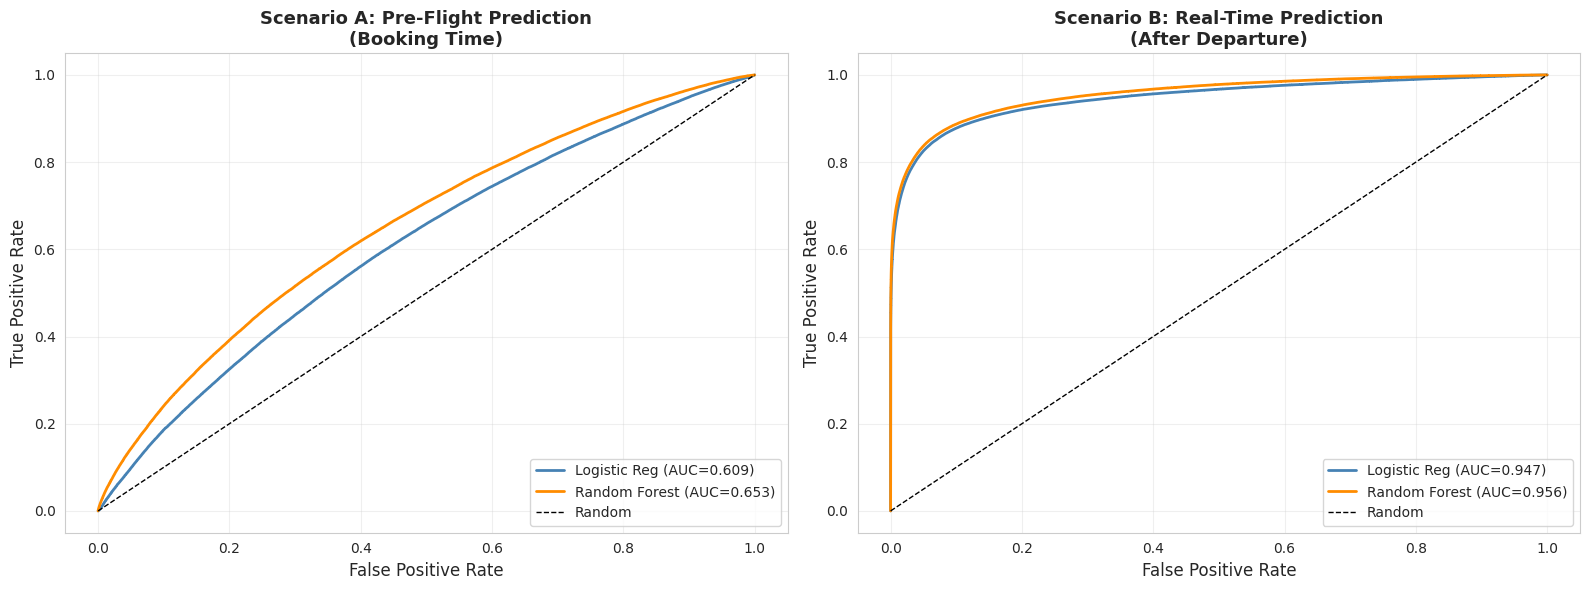

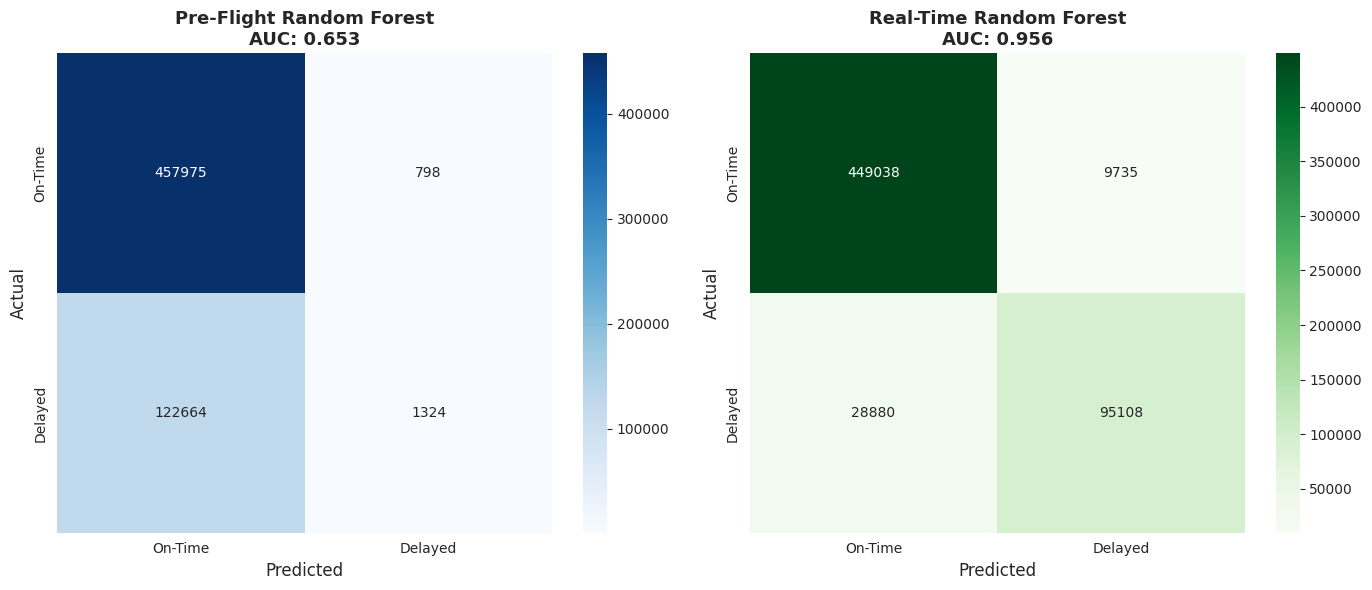

In [24]:
# ROC Curves - All 4 Models
from sklearn.metrics import roc_curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pre-Flight Models
fpr_lr_pre, tpr_lr_pre, _ = roc_curve(y_test_pre, y_proba_lr_pre)
fpr_rf_pre, tpr_rf_pre, _ = roc_curve(y_test_pre, y_proba_rf_pre)

ax1.plot(fpr_lr_pre, tpr_lr_pre,
         label=f'Logistic Reg (AUC={roc_auc_score(y_test_pre, y_proba_lr_pre):.3f})',
         linewidth=2, color='steelblue')
ax1.plot(fpr_rf_pre, tpr_rf_pre,
         label=f'Random Forest (AUC={roc_auc_score(y_test_pre, y_proba_rf_pre):.3f})',
         linewidth=2, color='darkorange')
ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Scenario A: Pre-Flight Prediction\n(Booking Time)', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Real-Time Models
fpr_lr_rt, tpr_lr_rt, _ = roc_curve(y_test_rt, y_proba_lr_rt)
fpr_rf_rt, tpr_rf_rt, _ = roc_curve(y_test_rt, y_proba_rf_rt)

ax2.plot(fpr_lr_rt, tpr_lr_rt,
         label=f'Logistic Reg (AUC={roc_auc_score(y_test_rt, y_proba_lr_rt):.3f})',
         linewidth=2, color='steelblue')
ax2.plot(fpr_rf_rt, tpr_rf_rt,
         label=f'Random Forest (AUC={roc_auc_score(y_test_rt, y_proba_rf_rt):.3f})',
         linewidth=2, color='darkorange')
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Scenario B: Real-Time Prediction\n(After Departure)', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrices - Best Models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pre-Flight (Random Forest)
cm_pre = confusion_matrix(y_test_pre, y_pred_rf_pre)
sns.heatmap(cm_pre, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['On-Time', 'Delayed'],
            yticklabels=['On-Time', 'Delayed'])
ax1.set_title(f'Pre-Flight Random Forest\nAUC: {roc_auc_score(y_test_pre, y_proba_rf_pre):.3f}',
              fontsize=13, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# Real-Time (Random Forest)
cm_rt = confusion_matrix(y_test_rt, y_pred_rf_rt)
sns.heatmap(cm_rt, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['On-Time', 'Delayed'],
            yticklabels=['On-Time', 'Delayed'])
ax2.set_title(f'Real-Time Random Forest\nAUC: {roc_auc_score(y_test_rt, y_proba_rf_rt):.3f}',
              fontsize=13, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()

### 10.5 Feature Importance

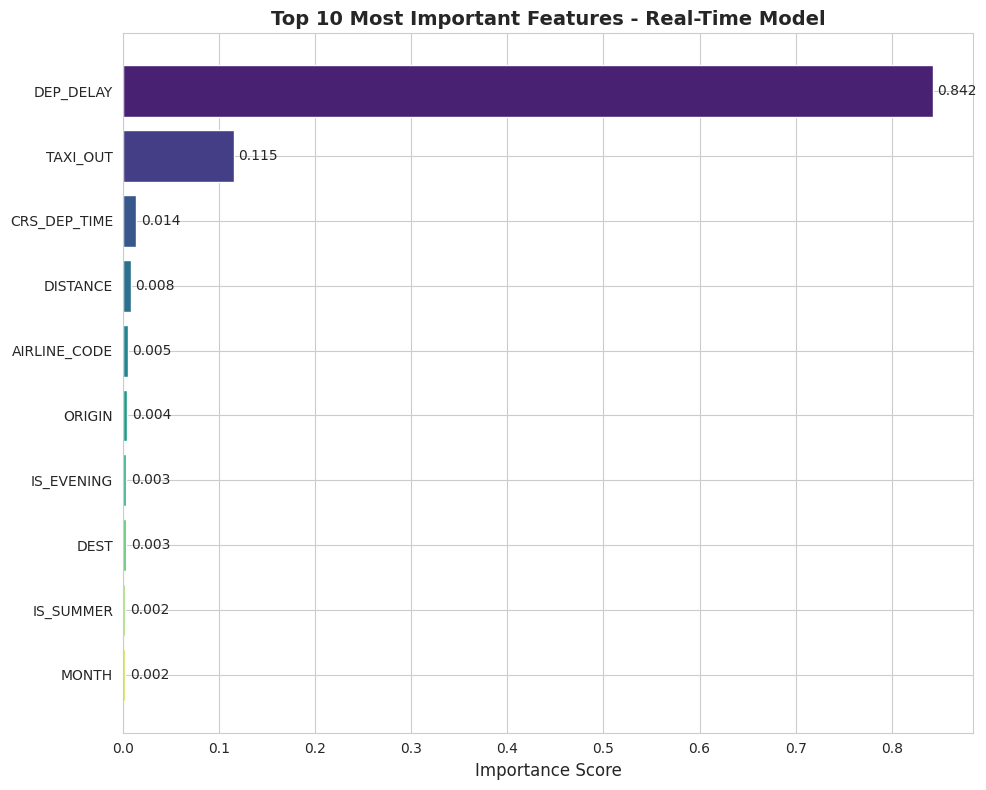


Top 10 Feature Importance (Real-Time Model):


,Feature,Importance
10,DEP_DELAY,0.842406
11,TAXI_OUT,0.115139
5,CRS_DEP_TIME,0.013710
6,DISTANCE,0.007878
0,AIRLINE_CODE,0.004907
1,ORIGIN,0.004368
9,IS_EVENING,0.003425
2,DEST,0.002990
8,IS_SUMMER,0.002067
3,MONTH,0.001978


In [25]:
# Feature Importance - Real-Time Model
feature_importance = pd.DataFrame({
    'Feature': X_realtime.columns,
    'Importance': rf_rt.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'],
         color=sns.color_palette('viridis', len(top_features)))
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Most Important Features - Real-Time Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

for i, (feat, imp) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
    plt.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nTop 10 Feature Importance (Real-Time Model):")
display(feature_importance.head(10))


## 11. Key Findings and Insights

### 11.1 Performance Summary

In [26]:
# Generate comprehensive summary
summary = con.execute("""
    WITH overall_stats AS (
        SELECT
            COUNT(*) as total_flights,
            SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) as delayed_flights,
            ROUND(100.0 * SUM(CASE WHEN IS_DELAYED = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as overall_delay_rate,
            ROUND(AVG(ARR_DELAY), 2) as overall_avg_delay,
            ROUND(SUM(ARR_DELAY) / 60.0, 0) as total_delay_hours
        FROM flights_clean
    )
    SELECT * FROM overall_stats
""").fetchdf()

print("=" * 70)
print("FLIGHT DELAY ANALYSIS - EXECUTIVE SUMMARY (2019-2023)")
print("=" * 70)
print(f"\n Dataset Overview:")
print(f"   • Total flights analyzed: {summary['total_flights'][0]:,}")
print(f"   • Flights delayed (>10 min): {summary['delayed_flights'][0]:,}")
print(f"   • Overall delay rate: {summary['overall_delay_rate'][0]:.1f}%")
print(f"   • Average delay: {summary['overall_avg_delay'][0]:.2f} minutes")
print(f"   • Total delay time: {summary['total_delay_hours'][0]:,.0f} hours")

print(f"\n Airline Performance:")
print(f"   • Best: {airline_delays.iloc[0]['AIRLINE']} ({airline_delays.iloc[0]['avg_delay_min']:.1f} min avg)")
print(f"   • Worst: {airline_delays.iloc[-1]['AIRLINE']} ({airline_delays.iloc[-1]['avg_delay_min']:.1f} min avg)")

print(f"\n Temporal Patterns:")
print(f"   • Peak delay year: {yearly_delays.loc[yearly_delays['total_delay_min'].idxmax(), 'YEAR']}")
print(f"   • Lowest delay year: {min_year} (COVID-19 impact)")
print(f"   • Worst day: {dow_analysis.loc[dow_analysis['delay_rate'].idxmax(), 'day_name']}")

print(f"\n Root Causes:")
primary_cause = max(delay_pct, key=delay_pct.get)
print(f"   • Primary: {primary_cause} ({delay_pct[primary_cause]:.1f}%)")
print(f"   • Secondary: Carrier Issues ({delay_pct['Carrier']:.1f}%)")
print(f"   • Combined (Late Aircraft + Carrier): {delay_pct['Late Aircraft'] + delay_pct['Carrier']:.1f}%")

print("\n" + "=" * 70)

FLIGHT DELAY ANALYSIS - EXECUTIVE SUMMARY (2019-2023)

 Dataset Overview:
   • Total flights analyzed: 2,913,802
   • Flights delayed (>10 min): 619,939.0
   • Overall delay rate: 21.3%
   • Average delay: 4.26 minutes
   • Total delay time: 206,922 hours

 Airline Performance:
   • Best: Hawaiian Airlines Inc. (22.1 min avg)
   • Worst: JetBlue Airways (54.0 min avg)

 Temporal Patterns:
   • Peak delay year: 2022
   • Lowest delay year: 2020 (COVID-19 impact)
   • Worst day: Thursday

 Root Causes:
   • Primary: Late Aircraft (37.7%)
   • Secondary: Carrier Issues (36.7%)
   • Combined (Late Aircraft + Carrier): 74.4%




### 11.2 Recommendations

In [27]:
print("\n RECOMMENDATIONS FOR AIRLINES:\n")
print("1. ADDRESS LATE AIRCRAFT DELAYS (37.7% of delays)")
print("   → Implement better turnaround time management")
print("   → Add buffer time in schedules for high-traffic routes")
print("   → Improve crew scheduling to prevent cascading delays")

print("\n2. OPTIMIZE CARRIER OPERATIONS (36.7% of delays)")
print("   → Review maintenance schedules to reduce delays")
print("   → Streamline ground operations")
print("   → Invest in staff training and equipment")

print("\n3. TEMPORAL OPTIMIZATION")
print("   → Avoid peak delay hours (late afternoon/evening)")
print("   → Allocate more resources during summer months")
print("   → Plan for Friday traffic surges")

print("\n4. ROUTE-SPECIFIC STRATEGIES")
print("   → Focus on high-traffic routes with poor performance")
print("   → Consider alternate airports for problematic routes")
print("   → Adjust schedules based on historical delay patterns")

print("\n5. WEATHER PREPAREDNESS")
print("   → Despite being only 5.9% of delays, weather is unpredictable")
print("   → Develop robust contingency plans")
print("   → Invest in weather prediction technology")


 RECOMMENDATIONS FOR AIRLINES:

1. ADDRESS LATE AIRCRAFT DELAYS (37.7% of delays)
   → Implement better turnaround time management
   → Add buffer time in schedules for high-traffic routes
   → Improve crew scheduling to prevent cascading delays

2. OPTIMIZE CARRIER OPERATIONS (36.7% of delays)
   → Review maintenance schedules to reduce delays
   → Streamline ground operations
   → Invest in staff training and equipment

3. TEMPORAL OPTIMIZATION
   → Avoid peak delay hours (late afternoon/evening)
   → Allocate more resources during summer months
   → Plan for Friday traffic surges

4. ROUTE-SPECIFIC STRATEGIES
   → Focus on high-traffic routes with poor performance
   → Consider alternate airports for problematic routes
   → Adjust schedules based on historical delay patterns

5. WEATHER PREPAREDNESS
   → Despite being only 5.9% of delays, weather is unpredictable
   → Develop robust contingency plans
   → Invest in weather prediction technology
